In [114]:
import time
from datetime import datetime
import pickle
import numpy as np
import pandas as pd


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## <span style="font-family: cursive;">Прогноз цен на металлы.</span>

![Intro](data/intro.jpg)

---

## Описание проекта:
Основная задача:

- Создать модель, прогнозирующую спотовую цену на металл (в нашем случае медь) с горизонтом планирования 3 месяца. Затем аггрегировать показатели по месяцу, выводя среднюю цену периода плюс границы доверительного интервала для прогноза.

- Воссоздать модель в компактном и мобильном виде, как базовый инструмент для более глубокого анализа рынков металлов. С высокой степенью устойчивости в контексте источников данных, что продиктованно необходимостью ежедневного уточнения прогноза.

- Со звездочкой. Задеплоить микросервис на рабочий сервер, но есть нюанс, что этот момент скорее всего будет выполнен в виде подтверждения исполнения, т.к. ели будет приянто решение использовать в реальной работе, то автоматом попадет под внутреннюю разработку нынешней компании и комерческую тайну.

Выбор метрики:

- Для прогнозирования возьмем в расчет ориентир на MAE, RMSE и MAPE. С концентрацией на MAE.

- RMSE измеряет среднеквадратичное отклонение между прогнозируемыми значениями и фактическими значениями. Она более чувствительна к большим ошибкам, так как она берет квадрат каждой ошибки. RMSE также имеет ту же размерность, что и исходные данные, что может быть полезно для интерпретации результатов.

- MAE, с другой стороны, измеряет среднюю абсолютную ошибку между прогнозируемыми значениями и фактическими значениями. Она не учитывает направление ошибки и может быть полезна, когда все ошибки равнозначны, что для нас является ключевым фактором при прогнозе средних значений.

- Пороговым значением MAE примем 150-200$.

Описание датасета:

- Датасет парсится с сайта westmetall, который в свою очередь аггрегирует информацию с Лондонской биржи металлов (LME).

- Избан единственный источник данных в следствие необходимости создания бенчмарка для LME высокой степени устойчивости, что с одной стороны понижает точность прогноза (наиболее вероятно), но с другой обеспечивает надежность. 

- В данном исследовании приводится анализ единственного металла, но парсер пополняет базу данных для всех ключевых non-ferrous metalls. Данные не имеют как таковых выбросов, т.к. формируются на основании временных рядов цен и запасов металлов, отражая реальную коньюктуру рынка, но могут содержаться аномалии.

P.S. Для упрощения анализа других металлов максимально унифицировал шаблон действий. В соседних файлах будет аналитика по аллюминию, цинку, свинцу, никелю.

---

### Технический блок.

### Содержание:
- Без парсера, берем данные из базы.
- Функции для использования в исследовании

---

- Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [115]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [116]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())

    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для {name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    print('\n')
    result_row = f'\n{date_of_experiment},{name},{rmse},{mae},{mape}'

    return result_row

In [117]:
# Функция для логирования метрик
def log_metrics_stock(metric):
    with open('./data/errors/stock_aluminium.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/stock_aluminium.csv', 'a') as file:
                file.write(metric)


def log_metrics_spot(metric):
    with open('./data/errors/spot_aluminium.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/spot_aluminium.csv', 'a') as file:
                file.write(metric)

In [118]:
# Функция для построения графиков
def visualisation_prog(pred_df, forecast_df, train_df, test_df, name=''):
    plt.plot(pred_df, label='Prediction')
    plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
    plt.plot(train_df, label='Training Data')
    plt.plot(test_df, label='Test Data')
    plt.title(f'Прогноз для {name}')
    plt.legend()
    plt.show()

In [119]:
# Функция для кодирования даты
def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)

---

### Часть 0.

- Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [120]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/aluminium.csv',
                parse_dates=['date'], index_col=['date'])

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
count,3981.000000,3981.000000,3981.000000
mean,2046.751947,2009.265134,2735.261279
std,411.895391,485.119678,1742.347669
min,0.000000,0.000000,0.000000
25%,1761.500000,1778.000000,1149.725000
50%,1975.500000,1972.500000,2188.400000
75%,2260.000000,2251.500000,4564.575000
max,3984.500000,3968.000000,5492.325000


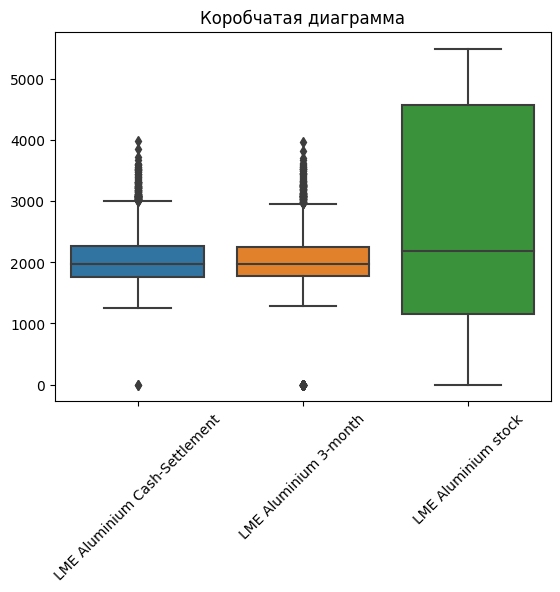

In [121]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

> Мы обнаружили аномалию - пропуск в данных

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
count,3897.000000,3897.000000,3897.000000
mean,2029.394791,2052.073005,2771.301289
std,392.678824,390.607873,1741.909030
min,1253.500000,1288.500000,271.450000
25%,1756.500000,1787.000000,1180.400000
50%,1965.500000,1984.000000,2245.050000
75%,2236.500000,2260.500000,4568.375000
max,3984.500000,3968.000000,5492.325000


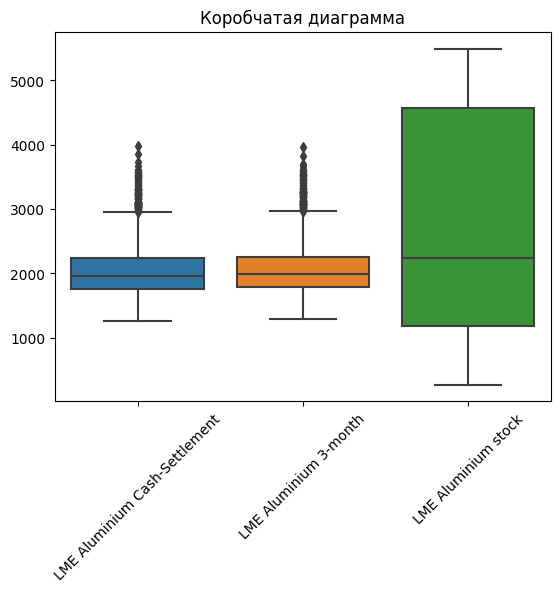

In [122]:
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

- Для последующего разложения и моделирования было принято решени о произведении интерполяции данных, итоговая точность прогноза от данных действий пострадает не сильно, учитывая, что нас не интересует дневной уровень цены

In [123]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [124]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2008]

display(data.head(), data.tail())

,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
365,2009-01-01,1473.500000,2301.000000,2333.600000
366,2009-01-02,1492.000000,2285.666667,2338.300000
367,2009-01-03,1499.833333,2270.333333,2340.608333
368,2009-01-04,1507.666667,2255.000000,2342.916667
369,2009-01-05,1515.500000,2275.000000,2345.225000


,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
85,2023-12-22,NaN,2230.0,NaN
86,2023-12-23,NaN,2225.0,NaN
87,2023-12-24,NaN,2238.5,NaN
88,2023-12-25,NaN,2226.0,NaN
89,2023-12-26,NaN,2265.0,NaN


---

#### Посмотрим на корреляцию между параметрами и целевой переменной

Диапазон планирования равен 90 дней


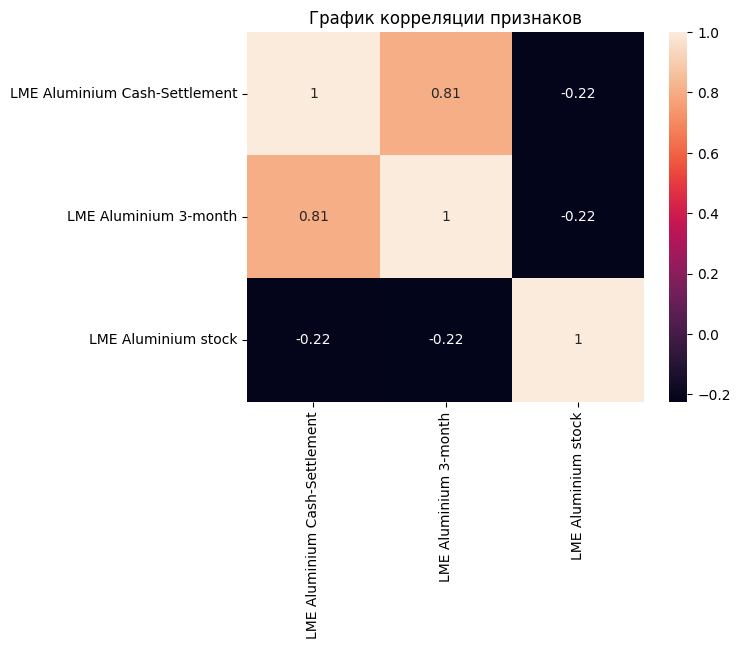

In [125]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data.iloc[:, 3].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data.iloc[:, 3].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

> Можно наблюдать высокий уровень корреляции между фьючерсной ценой и спотом, что понадобится нам потом и какую-то между запасами и спотом, что тоже лучше чем ничего.
> На основании того что у нас есть фиты с сильной корреляцией к целевой переменной, мы можем попробовать что-то большее чем стандартный набор для прогнозирования временных рядов.

---

Исходя из первичного анализа данных вырисовывается следующий план:
- Протестировать модели прогноза временных рядов для запасов и цены с последующим логированием
- Протестировать ML- методы линейной регрессии

---

#### Посмотри на распределение показателей с которыми мы будем работать

<Axes: xlabel='LME Aluminium Cash-Settlement', ylabel='Count'>

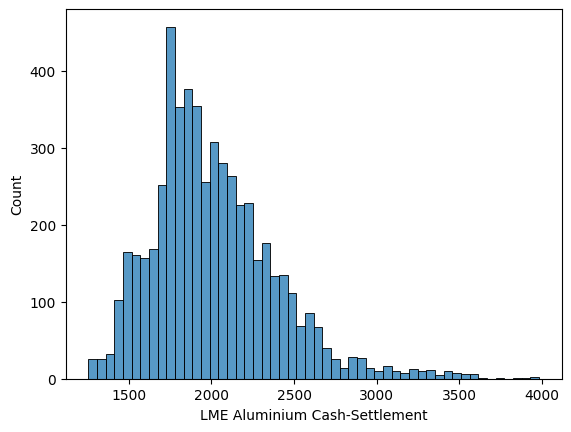

In [126]:
# Посмотрим на распределения цены и запасов
sns.histplot(data.iloc[:, 1])

По цене нормальное распределение

<Axes: xlabel='LME Aluminium stock', ylabel='Count'>

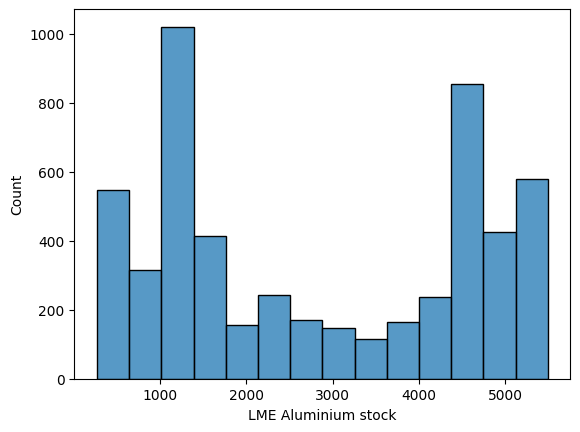

In [127]:
sns.histplot(data.iloc[:, -1])

<Axes: xlabel='LME Aluminium stock', ylabel='Count'>

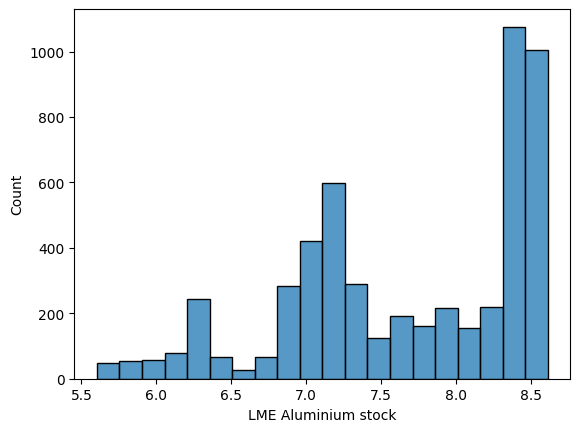

In [128]:
sns.histplot(np.log(data.iloc[:, -1]))

По запасам логнормальное, это может понадобиться в будущем (не понадобится, в итоге лучше принимать его за нормальное и не логарифмировать, но об этом позже)

---

Предварительный вывод и личные коментарии:
- Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.

- Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.

- Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

### Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [129]:
# Будем прогнозировать временной ряд LME Copper stock и
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data.iloc[:, 2]
spot = working_data.iloc[:, 0]

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)

# Выделим тренд, сезонность и остатки, интерполируем и заполним нулями первые элементы
trend_stock = decompose_stock.trend
seasonal_stock = decompose_stock.seasonal
seasonal_stock = seasonal_stock.resample('d').interpolate(method='linear')
seasonal_stock.fillna(0, inplace=True)
residuals_stock = decompose_stock.resid
residuals_stock = residuals_stock.resample('d').interpolate(method='linear')
residuals_stock.fillna(0, inplace=True)

trend_spot = decompose_spot.trend
seasonal_spot = decompose_spot.seasonal
seasonal_spot = seasonal_spot.resample('d').interpolate(method='linear')
seasonal_spot.fillna(0, inplace=True)
resid_spot = decompose_spot.resid
resid_spot = resid_spot.resample('d').interpolate(method='linear')
resid_spot.fillna(0, inplace=True)

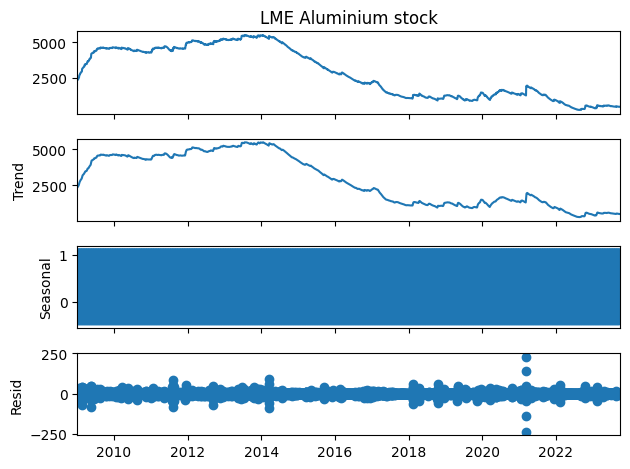

In [130]:
# Произвведем декомпозицию ряда
decompose_stock.plot()
plt.show()

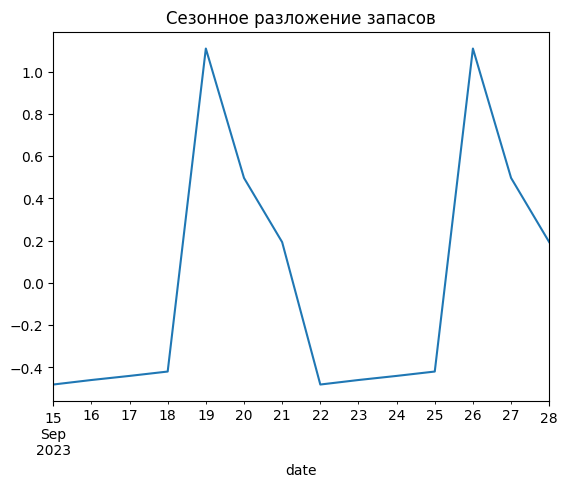

In [131]:
# Приблизим сезонность
graph = decompose_stock.seasonal[-14:].plot()
graph.set_title('Сезонное разложение запасов')
plt.show()

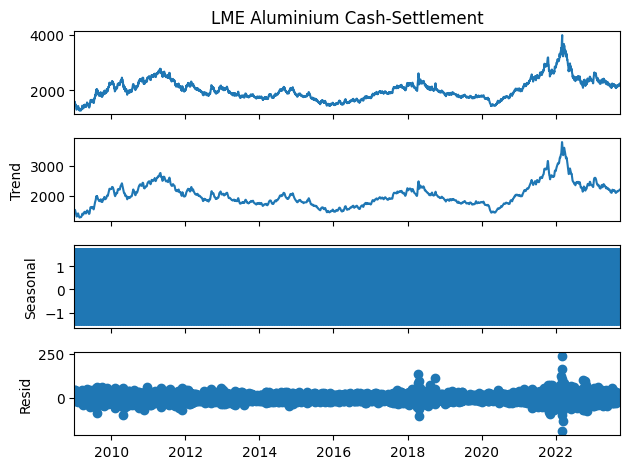

In [132]:
# Для цены
decompose_spot.plot()
plt.show()

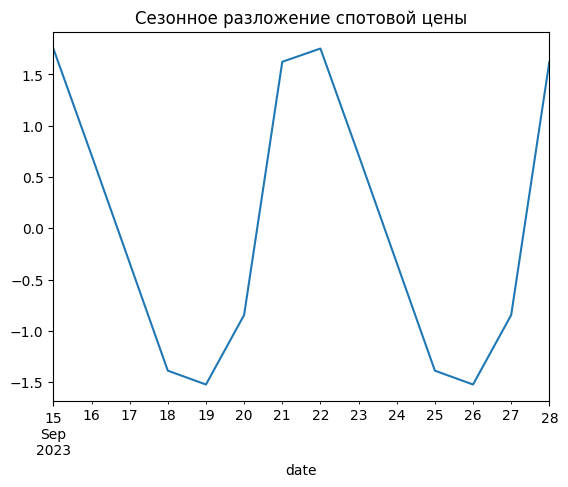

In [133]:
graph = decompose_spot.seasonal[-14:].plot()
graph.set_title('Сезонное разложение спотовой цены')
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.

> Так же нужно отметить сезонность равную периоду 7 дней (5 дней ьез интерполяции), что характерно для биржевых показателей.


---

Единичных корней нет, ряд стационарен
{'p_value': -10.21396789950108, 'crit_value (5%)': -2.8620799873379568}
Единичных корней нет, ряд стационарен
{'p_value': -22.905204863442822, 'crit_value (5%)': -2.8620782777314395}


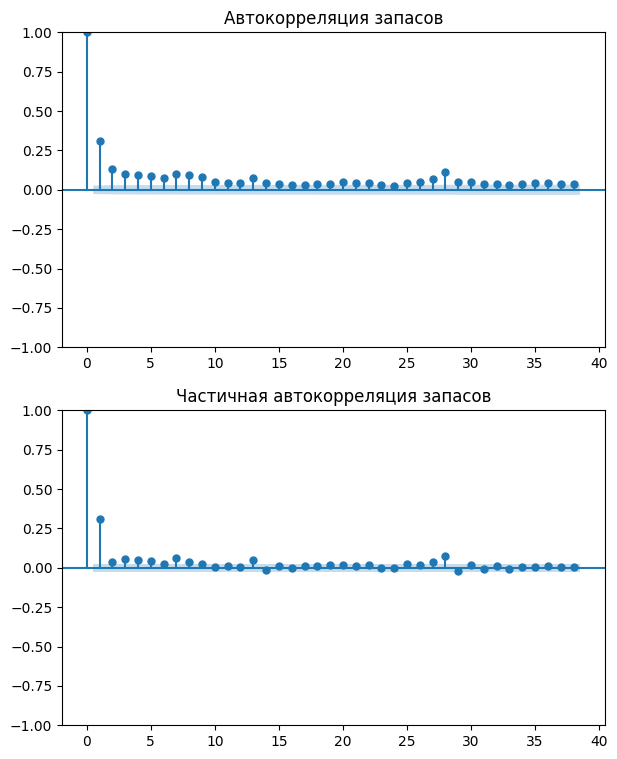

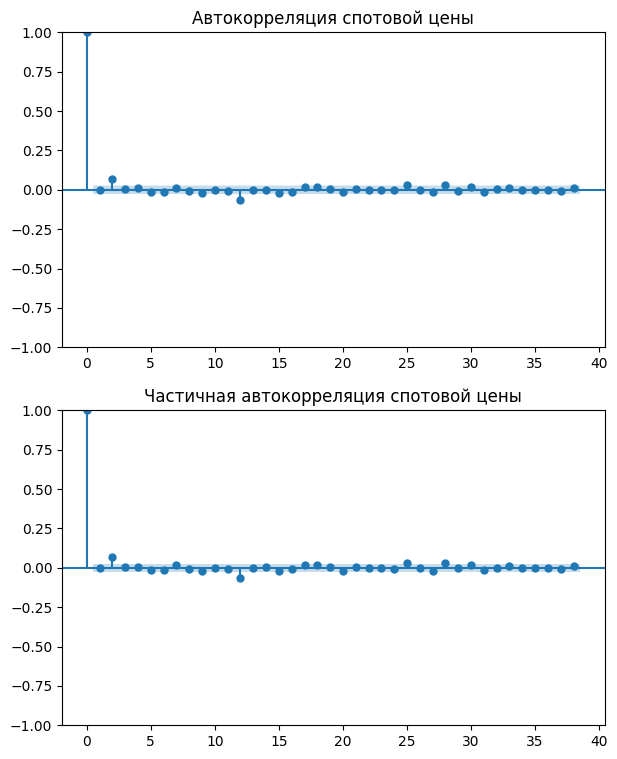

In [134]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock.diff().dropna(), name='запасов')
stationary_test(spot.diff().dropna(), name='спотовой цены')

> Вывод: оба ряда стационарны при дифференцировании 1 порядка, стоит отметить что ряд запасов условно стационарен (не все статистика близка к порогу 5%)

> p для запасов равен 1 (исходя из pacf графика это значение равно 2, но лучшие результаты были достигнуты именно при значении 1)

> p для спота равен 2 (так же исходя из pacf)

In [135]:
p_stock = 1
d_stock = 0
q_stock = 0

p_spot = 2
d_spot = 0
q_spot = 0

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [136]:
# Выделим тренировочную и тестовую выборки
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

# Сделаем то же самое для сезонных компонент
seasonal_stock_train = seasonal_stock[:-len(data_target)]
seasonal_stock_test = seasonal_stock[-len(data_target):]

residuals_stock_train = residuals_stock[:-len(data_target)]
residuals_stock_test = residuals_stock[-len(data_target):]

seasonal_spot_train = seasonal_spot[:-len(data_target)]
seasonal_spot_test = seasonal_spot[-len(data_target):]

resid_spot_train = resid_spot[:-len(data_target)]
resid_spot_test = resid_spot[-len(data_target):]

# И попробуем создать корректировку для послежующих прогнозов через базовую модель
ar_model_stock_sesonal = AutoReg(seasonal_stock_train, lags=1).fit()
ar_model_stock_resid = AutoReg(residuals_stock_train, lags=1).fit()

ar_model_spot_seasonal = AutoReg(seasonal_spot_train, lags=1).fit()
ar_model_spot_resid = AutoReg(resid_spot_train, lags=1).fit()

In [137]:
# Наши корректировки
stock_seasonal_mod = ar_model_stock_sesonal.predict(start=len(
    seasonal_stock_train), end=len(seasonal_stock_train)+len(seasonal_stock_test)-1)
stock_resid_mod = ar_model_stock_resid.predict(start=len(
    residuals_stock_train), end=len(residuals_stock_train)+len(residuals_stock_test)-1)

spot_seasonal_mod = ar_model_spot_seasonal.predict(start=len(
    seasonal_spot_train), end=len(seasonal_spot_train)+len(seasonal_spot_test)-1)
spot_resid_mod = ar_model_spot_resid.predict(start=len(
    resid_spot_train), end=len(resid_spot_train)+len(resid_spot_test)-1)

In [138]:
# Произведем прогнозирование
ar_model_stock = AutoReg(train_stock, lags=p_stock, seasonal=True).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot, seasonal=True).fit()

# Сделаем предсказание
pred_ar_stock = ar_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Подгоним полученные предсказания компонентами сезонного разложения
pred_ar_stock = pred_ar_stock + stock_seasonal_mod + stock_resid_mod

pred_ar_spot = pred_ar_spot + spot_seasonal_mod + spot_resid_mod

# Построим доверительный интервал
forecast_stock = ar_model_stock.get_prediction(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = ar_model_spot.get_prediction(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [139]:
# Оценим метрики и залогируем результаты
metric_stock = metrics_calculation(
    test_stock, pred_ar_stock, name='AR-baseline-stock')
log_metrics_stock(metric_stock)

metric_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='AR-baseline-spot')
log_metrics_spot(metric_spot)

RMSE для AR-baseline-stock: 13.893
MAE для AR-baseline-stock: 11.369
MAPE для AR-baseline-stock: 2.1999999999999997%


RMSE для AR-baseline-spot: 69.414
MAE для AR-baseline-spot: 59.149
MAPE для AR-baseline-spot: 2.7%




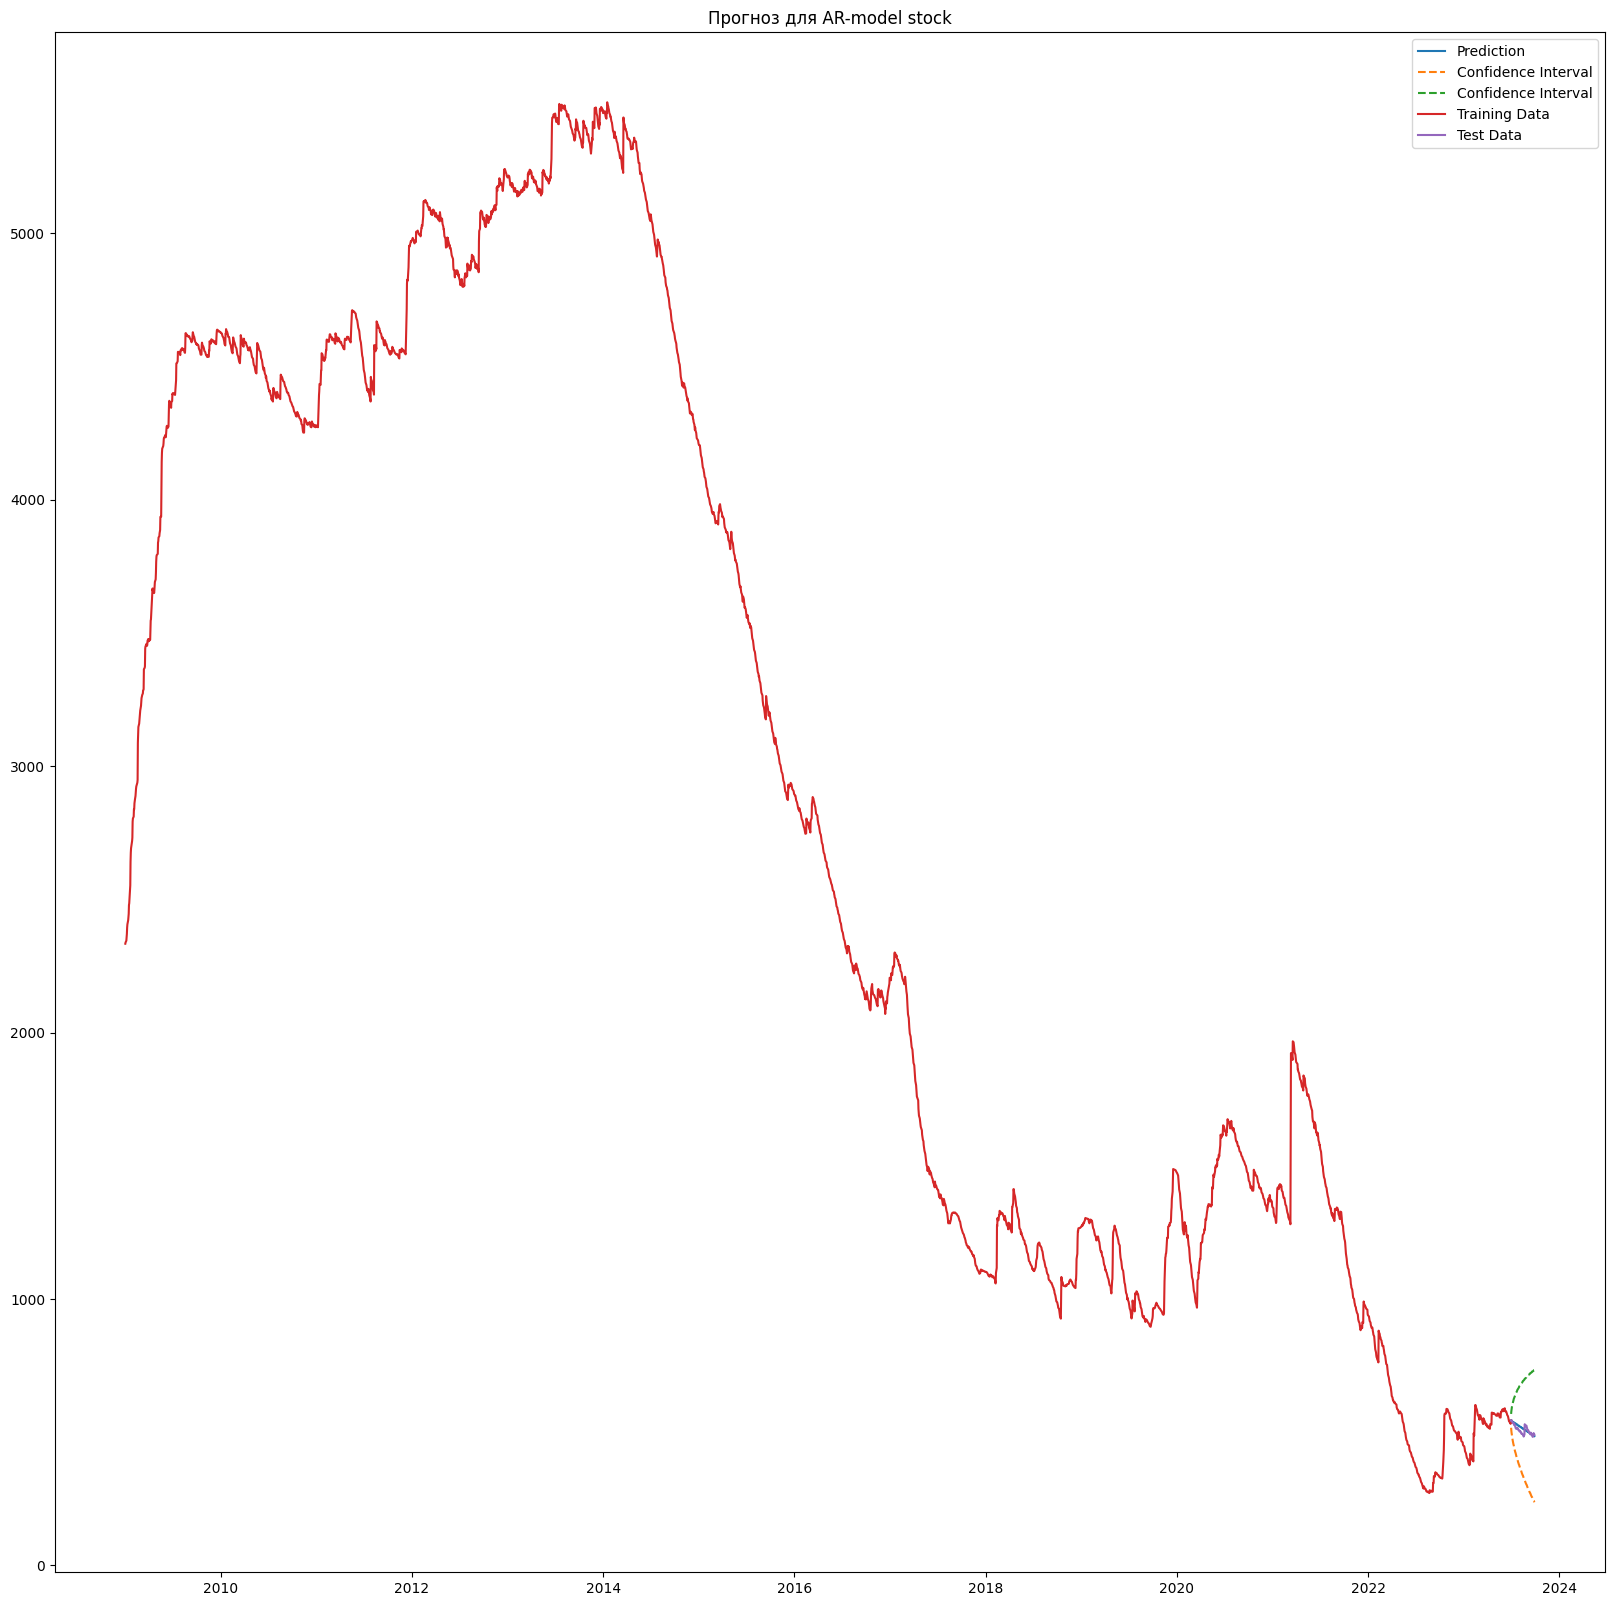

In [140]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

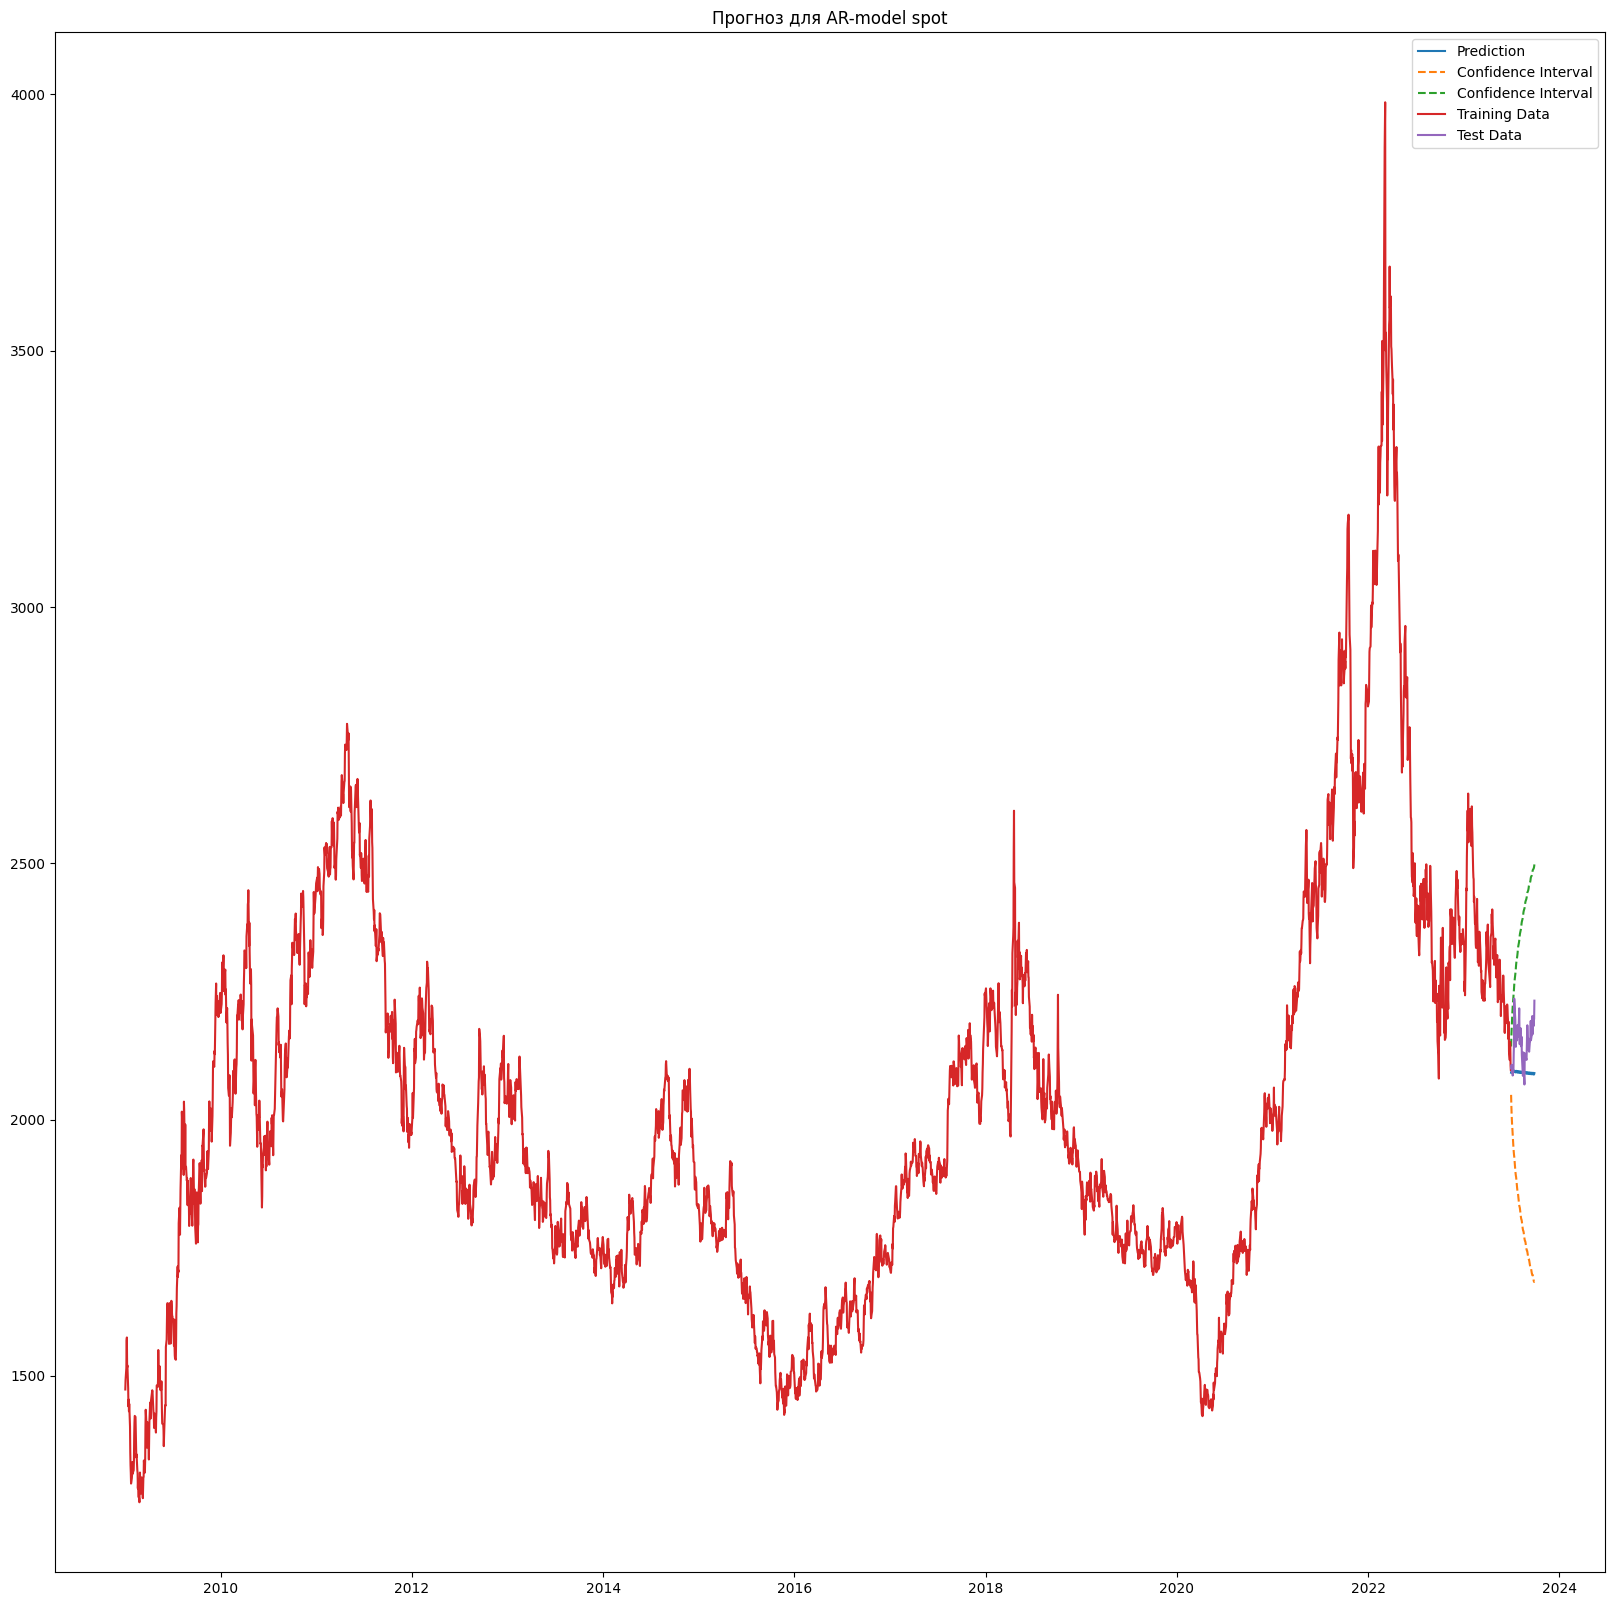

In [141]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

> Так же стоти отметить следующее:
 * Прогноз не уловил дисперисю
 * 95% доверительный интервал весьма широк
> Что говорит о вероято слабой прогностической способности в бою (если бы мы ставили целью прогноз именно запасов).

---

### ARIMA прогноз (т.к. ряды изначально не стационарны их порядок дифференцирования равен 1, d=1)

In [142]:
# Используем модель ARIMA
arima_model_stock = ARIMA(train_stock, order=(p_stock, d_stock, q_stock)).fit()
arima_model_spot = ARIMA(train_spot, order=(p_spot, d_stock, q_stock)).fit()

# Прогноз
pred_arima_stock = arima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_arima_spot = arima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Модификация прогноза
pred_arima_stock = pred_arima_stock + stock_seasonal_mod + stock_resid_mod

pred_arima_spot = pred_arima_spot + spot_seasonal_mod + spot_resid_mod

# Доверительные интервалы
forecast_stock = arima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = arima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [143]:
# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_arima_stock, name='ARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_arima_spot, name='ARIMA-spot'))

RMSE для ARIMA-stock: 41.894
MAE для ARIMA-stock: 37.808
MAPE для ARIMA-stock: 7.6%


RMSE для ARIMA-spot: 72.712
MAE для ARIMA-spot: 62.176
MAPE для ARIMA-spot: 2.9000000000000004%




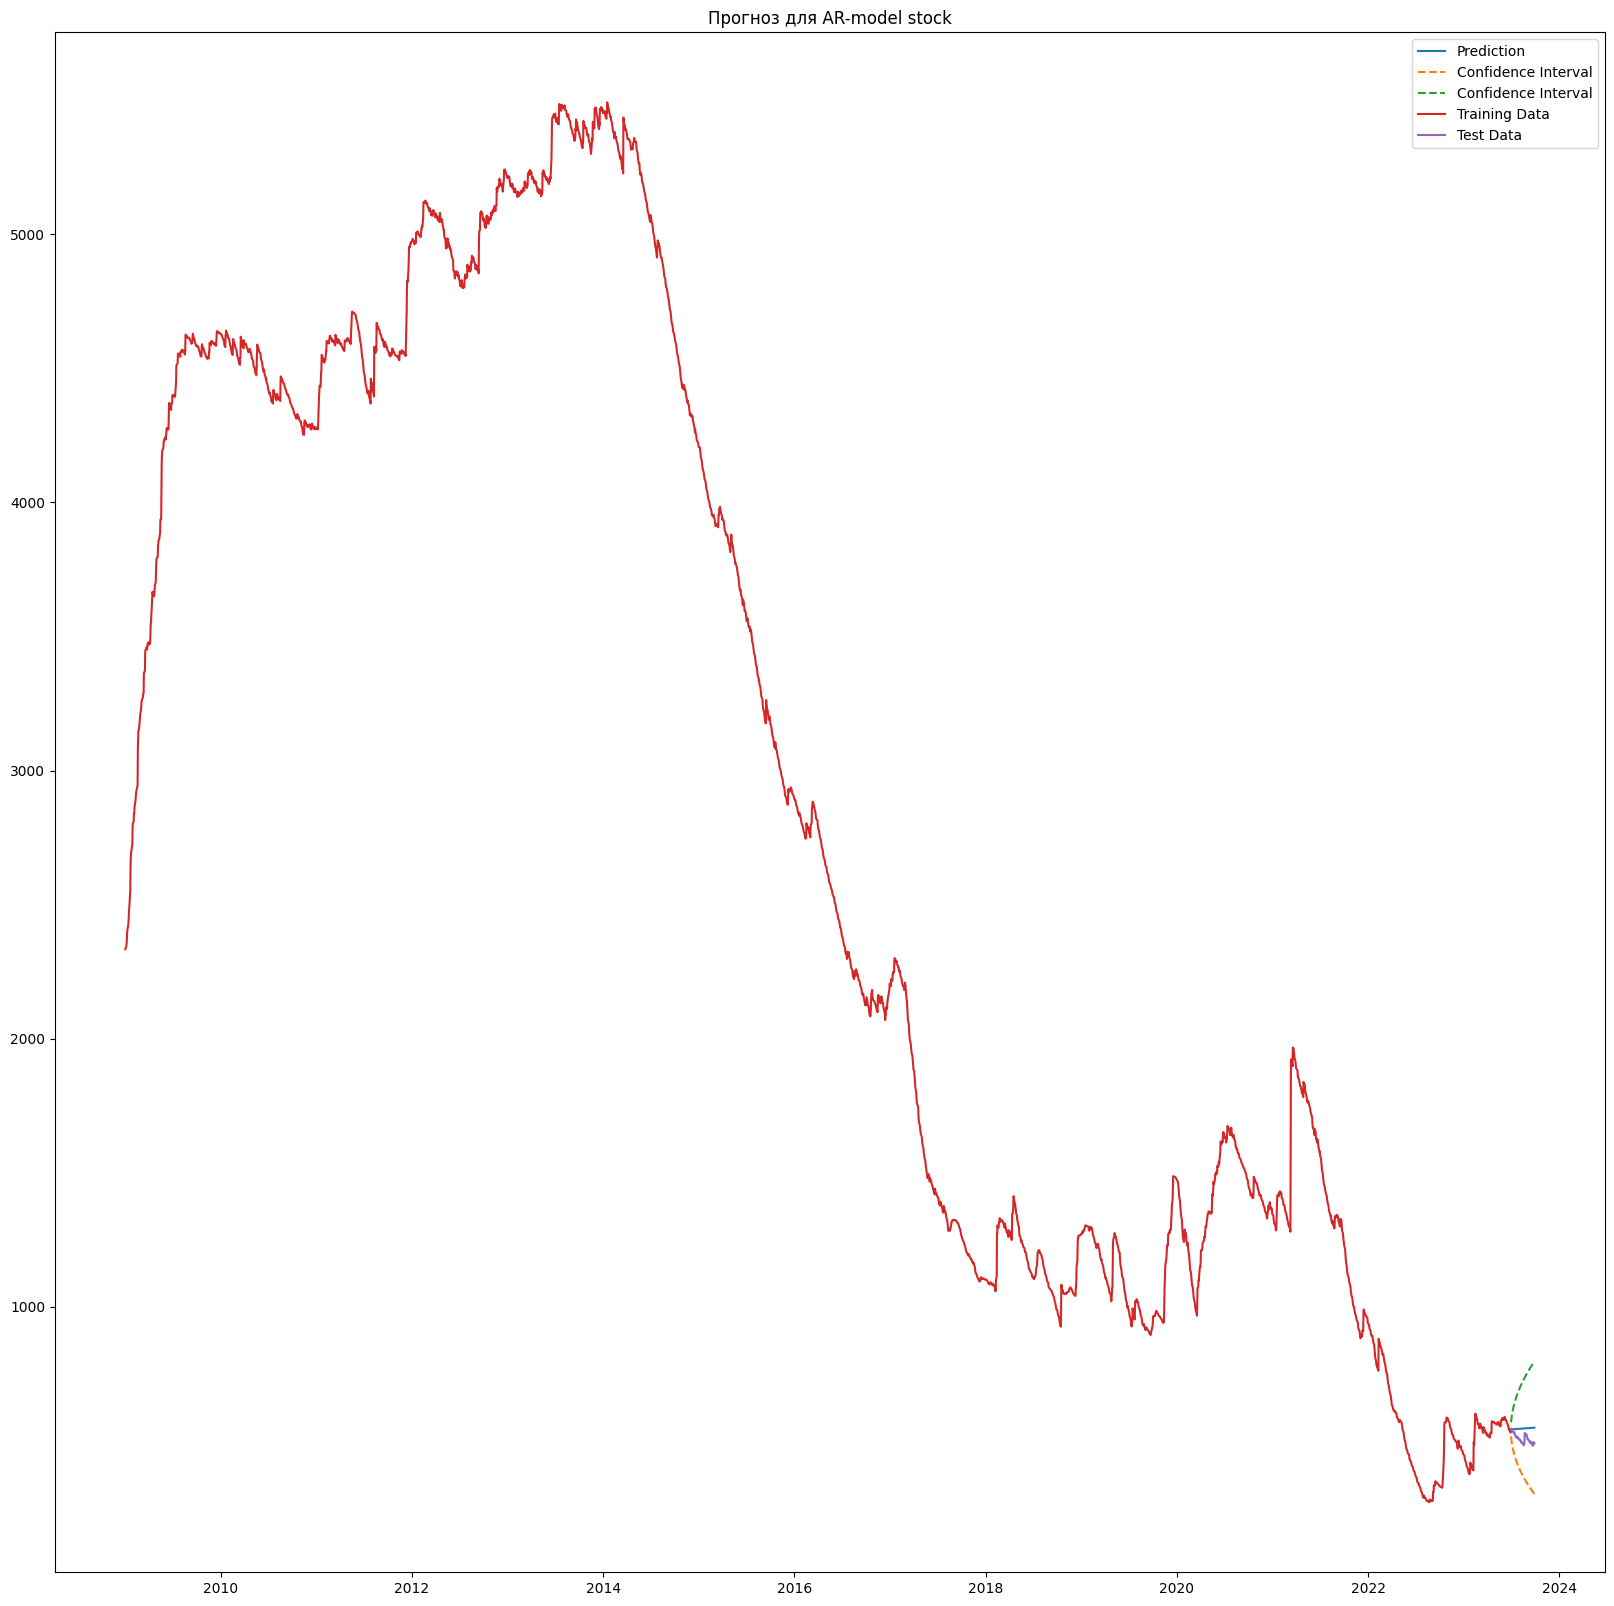

In [144]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

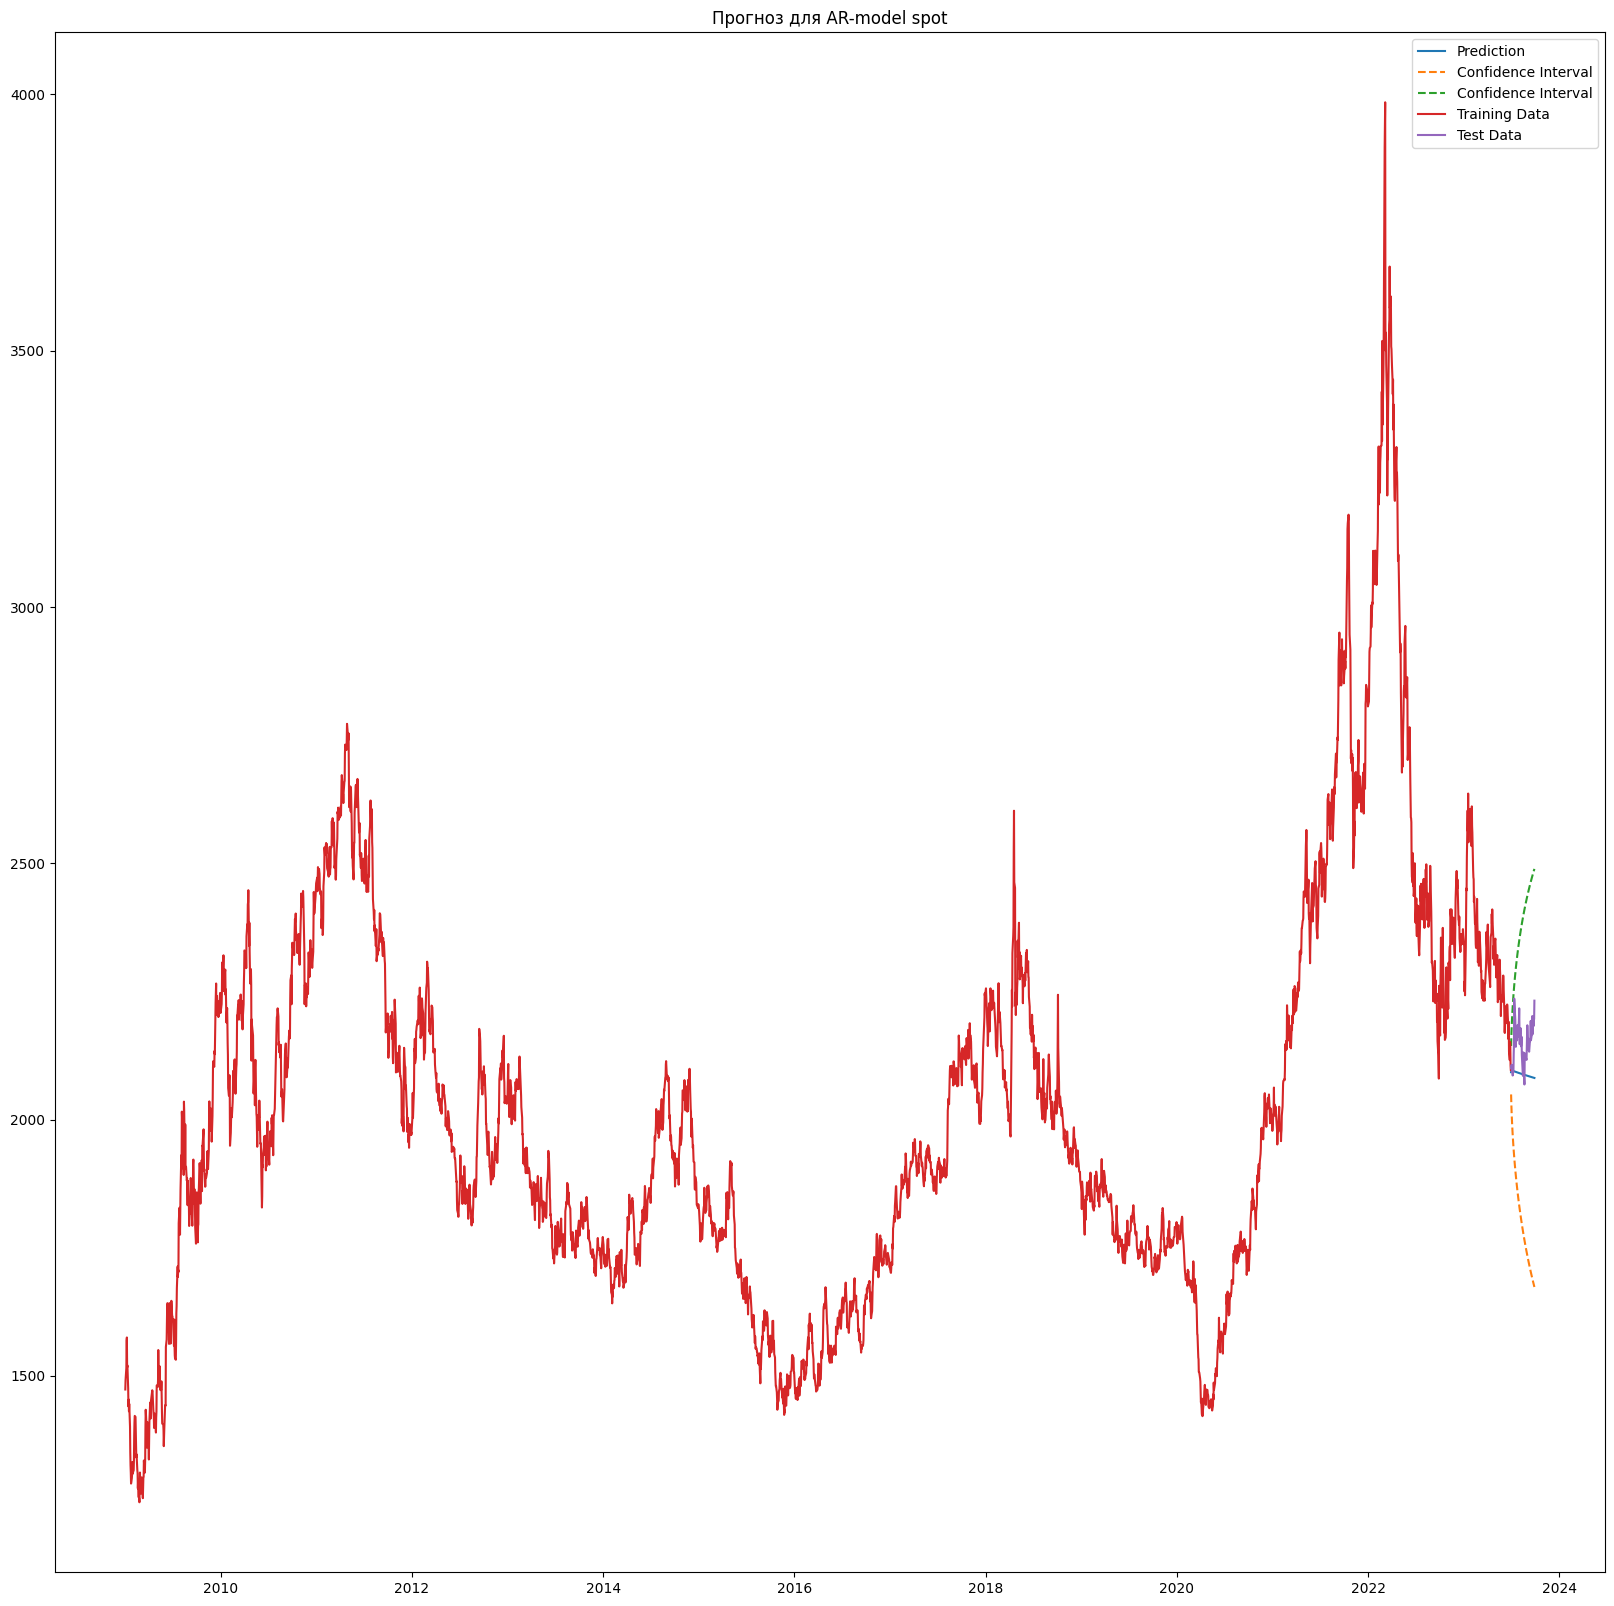

In [145]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> В сравнение с baseline моделью произошло незначительное падение метрики spot-price, и незначительное увеличение stocks, графики так же отражают весьма сомнительную прогностическую способность для дневного анализа, НО, и это важно подчеркнуть, так как нашей задачей является СРЕДНЯЯ ЦЕНА за тестовый период, можно сказать, что задача, исходя из проделанного на данный момент анализа, вполне достижима

> Так же отсутсвует чувствительность по дисеперсии и гигантские доверительные интервалы.

---

### PMDARIMA прогноз, попробуем подобрать внутренние параметры модели автоматом.

In [146]:
model_stock = pm.auto_arima(
    train_stock, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stock.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=45479.903, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=43811.313, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.56 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=45137.753, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=43200.159, Time=1.37 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.47 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.14 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=43585.647, Time=1.04 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=43200.529, Time=2.07 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=43199.926, Time=1.96 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=43811.857, Time=0.86 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=inf, Time=7.58 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=2.95 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=43231.210, Time=1.51 sec
 ARIMA(2,1,1)(2,1,0)[7]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5294
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -21590.583
Date:                           Fri, 29 Sep 2023   AIC                          43195.166
Time:                                   07:28:12   BIC                          43241.176
Sample:                               01-01-2009   HQIC                         43211.246
                                    - 06-30-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2599      0.003    100.462      0.000       0.255       0.265
ar.L2          0.0084      0.007      1.292      0.196      -0.004       0.021
ar.L3          0.0284      0.016      1.762      0.078      -0.003       0.060
ar.L4          0.0240      0.016      1.513      0.130      -0.007       0.055
ar.S.L7       -0.6302      0.003   -192.066      0.000      -0.637      -0.624
ar.S.L14      -0.3323      0.003   -100.661      0.000      -0.339      -0.326
sigma2       206.5292      0.600    344.185      0.000     205.353     207.705
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2217477.71
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             5.44
Prob(H) (two-sided):                  0.10   Kurtosis:                       102.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
model_spot = pm.auto_arima(
    train_spot, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_spot.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.04 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=52239.019, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=50786.303, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.95 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=52240.578, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=50155.692, Time=1.33 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.10 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=50153.920, Time=0.62 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=50784.754, Time=0.18 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=5.82 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=50155.725, Time=1.47 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=50149.342, Time=2.21 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=50775.813, Time=1.08 sec
 ARIMA(1,1,1)(2,1,1)[7]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5294
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -25054.651
Date:                           Fri, 29 Sep 2023   AIC                          50119.301
Time:                                   07:29:22   BIC                          50152.165
Sample:                               01-01-2009   HQIC                         50130.787
                                    - 06-30-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0060      0.009      0.684      0.494      -0.011       0.023
ar.L2          0.0853      0.009      9.481      0.000       0.068       0.103
ar.S.L7       -0.6567      0.006   -106.113      0.000      -0.669      -0.645
ar.S.L14      -0.3324      0.005    -65.574      0.000      -0.342      -0.323
sigma2       765.9991      4.419    173.348      0.000     757.338     774.660
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            178564.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
model_stock.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [149]:
with open('./data/ar_stock_al.pkl', 'wb') as pkl_file:
    pickle.dump(model_stock.get_params(), pkl_file)

In [150]:
model_spot.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [151]:
with open('./data/ar_spot_al.pkl', 'wb') as pkl_file:
    pickle.dump(model_spot.get_params(), pkl_file)

---

#### До этого момента я не сравнивал модели по критерию AIC ввиду того что по итогу все равно бы начал перебирать внутренние параметры для последующего использования SARIMAX


### ARIMA - по подобранным параметрам

In [152]:
order_stock = model_stock.order
seasonal_order_stock = model_stock.seasonal_order

order_spot = model_spot.order
seasonal_order_spot = model_spot.seasonal_order

In [153]:
# Используем модель ARIMA
pmarima_model_stock = ARIMA(
    train_stock, order=order_stock,
    seasonal_order=seasonal_order_stock).fit()

pmarima_model_spot = ARIMA(
    train_spot, order=order_spot,
    seasonal_order=seasonal_order_spot).fit()

# Прогноз
pred_pmarima_stock = pmarima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_pmarima_spot = pmarima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Доверительные интервалы
forecast_stock = pmarima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = pmarima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_pmarima_stock, name='PMARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_pmarima_spot, name='PMARIMA-spot'))

RMSE для PMARIMA-stock: 13.819
MAE для PMARIMA-stock: 11.574
MAPE для PMARIMA-stock: 2.3%


RMSE для PMARIMA-spot: 429.552
MAE для PMARIMA-spot: 379.703
MAPE для PMARIMA-spot: 17.599999999999998%




> Ухудшение метрик, усложнение можели не идет на пользу.

---

### SARIMAX

In [154]:
# Инициализация модели
sarimax_model_stock = SARIMAX(
    train_stock, order=order_stock, seasonal_order=seasonal_order_stock).fit()

sarimax_model_spot = SARIMAX(
    train_spot, order=order_spot, seasonal_order=seasonal_order_spot).fit()

# Спрогнозируем
pred_sarimax_stock = sarimax_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_sarimax_spot = sarimax_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Построим доверительные интервалы
forecast_stock = sarimax_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = sarimax_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_sarimax_stock, name='SARIMAX-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_sarimax_spot, name='SARIMAX-spot'))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10915D+00    |proj g|=  2.01875D-02

At iterate    5    f=  4.08700D+00    |proj g|=  7.47489D-02

At iterate   10    f=  4.07831D+00    |proj g|=  5.19956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     15      1     0     0   6.314D-06   4.078D+00
  F =   4.0783118505855915     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  4.73271D+00    |proj g|=  9.37748D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     14      1     0     0   6.750D-05   4.733D+00
  F =   4.7326502824178007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RMSE для SARIMAX-stock: 13.819
MAE для SARIMAX-stock: 11.574
MAPE для SARIMAX-stock: 2.3%


RMSE для SARIMAX-spot: 429.552
MAE для SARIMAX-spot: 379.703
MAPE для SARIMAX-spot: 17.599999999999998%




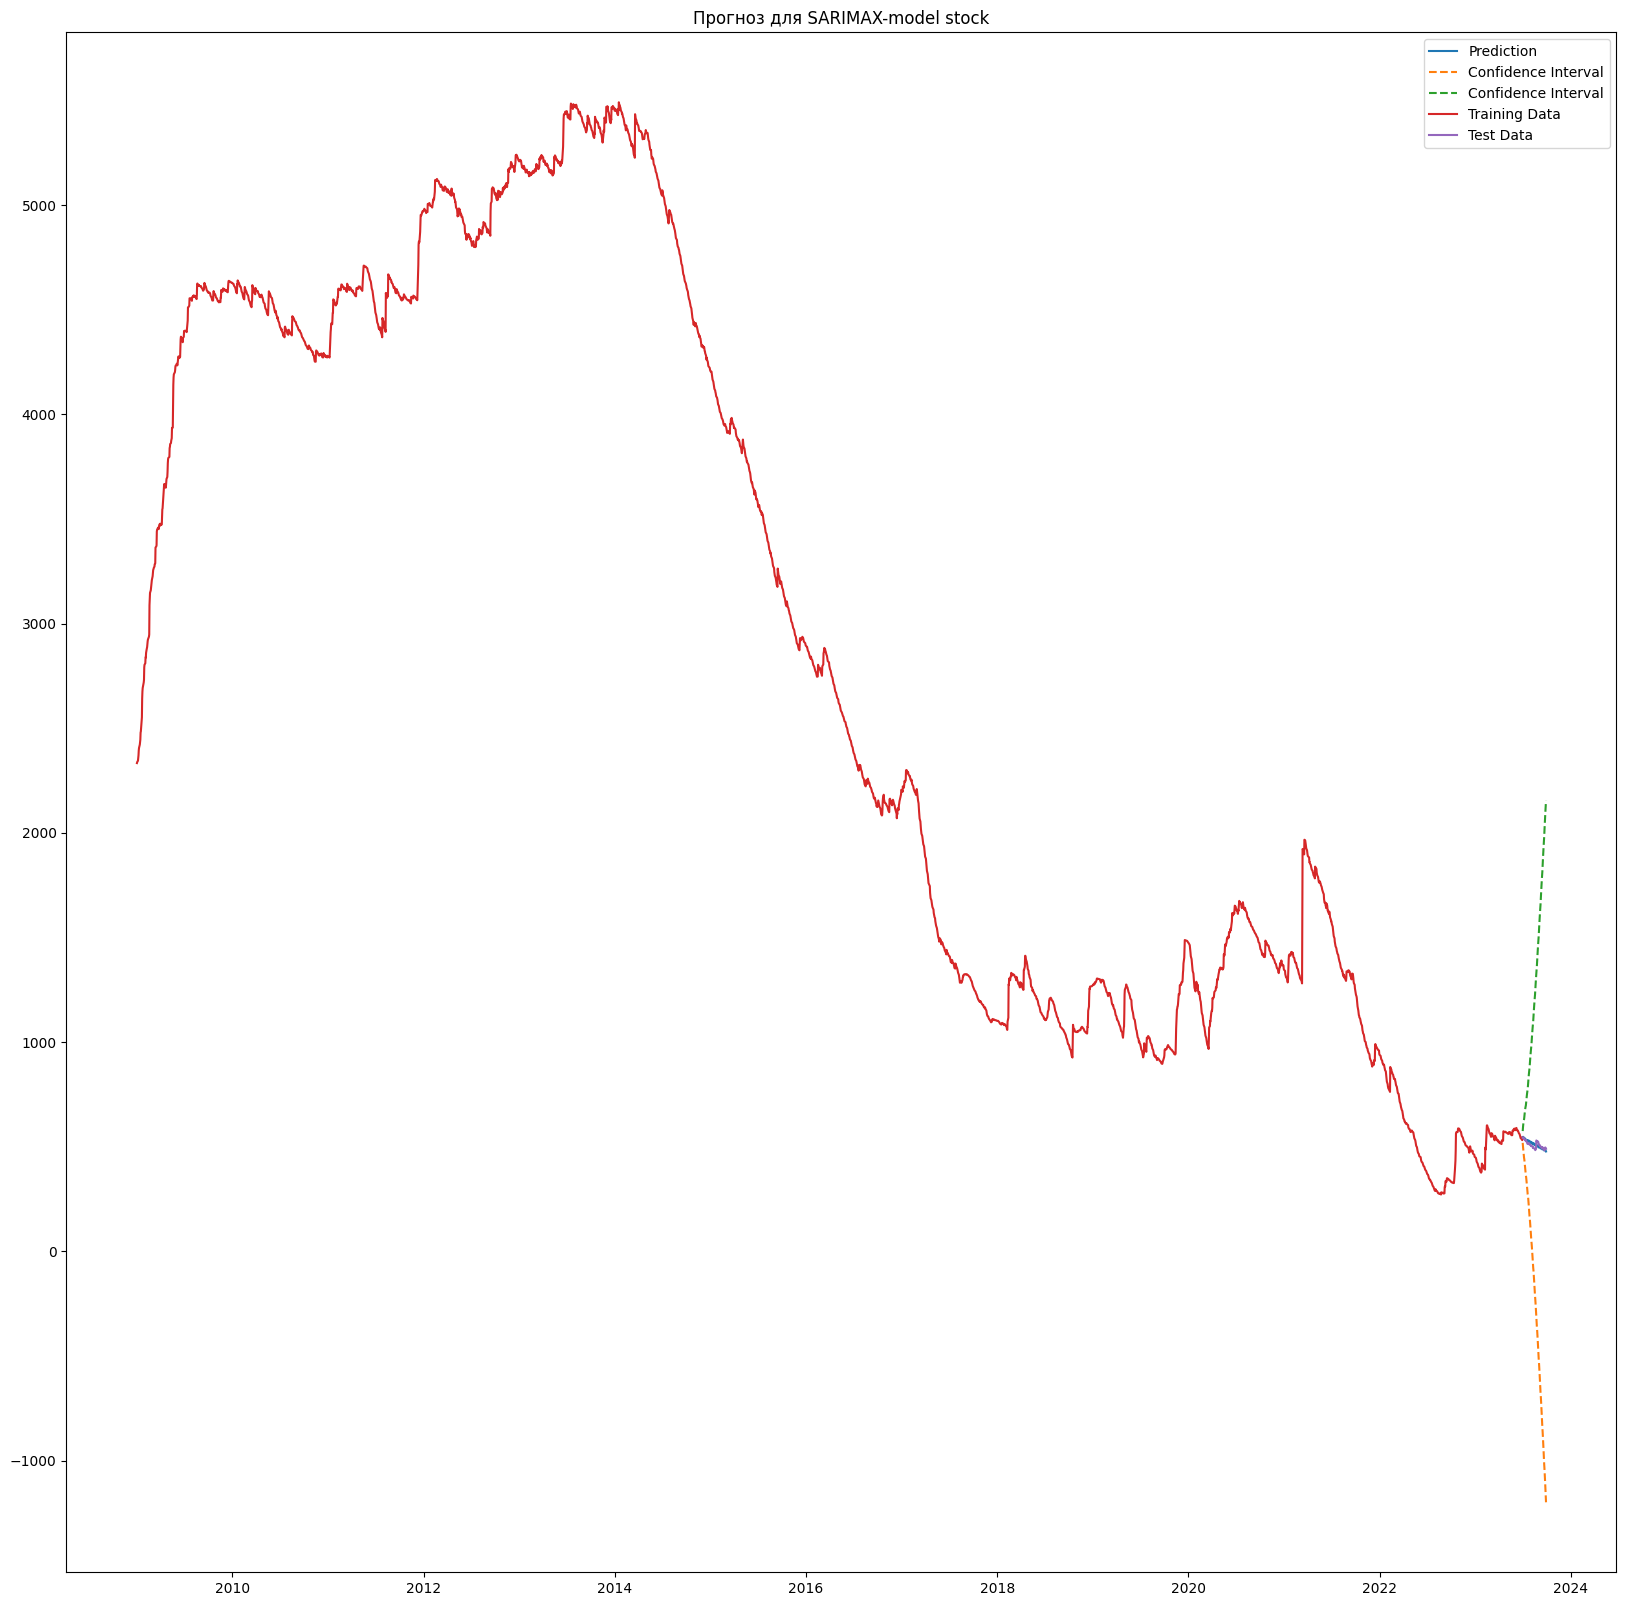

In [155]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_stock, conf_stock,
    train_stock, test_stock, name='SARIMAX-model stock'
)

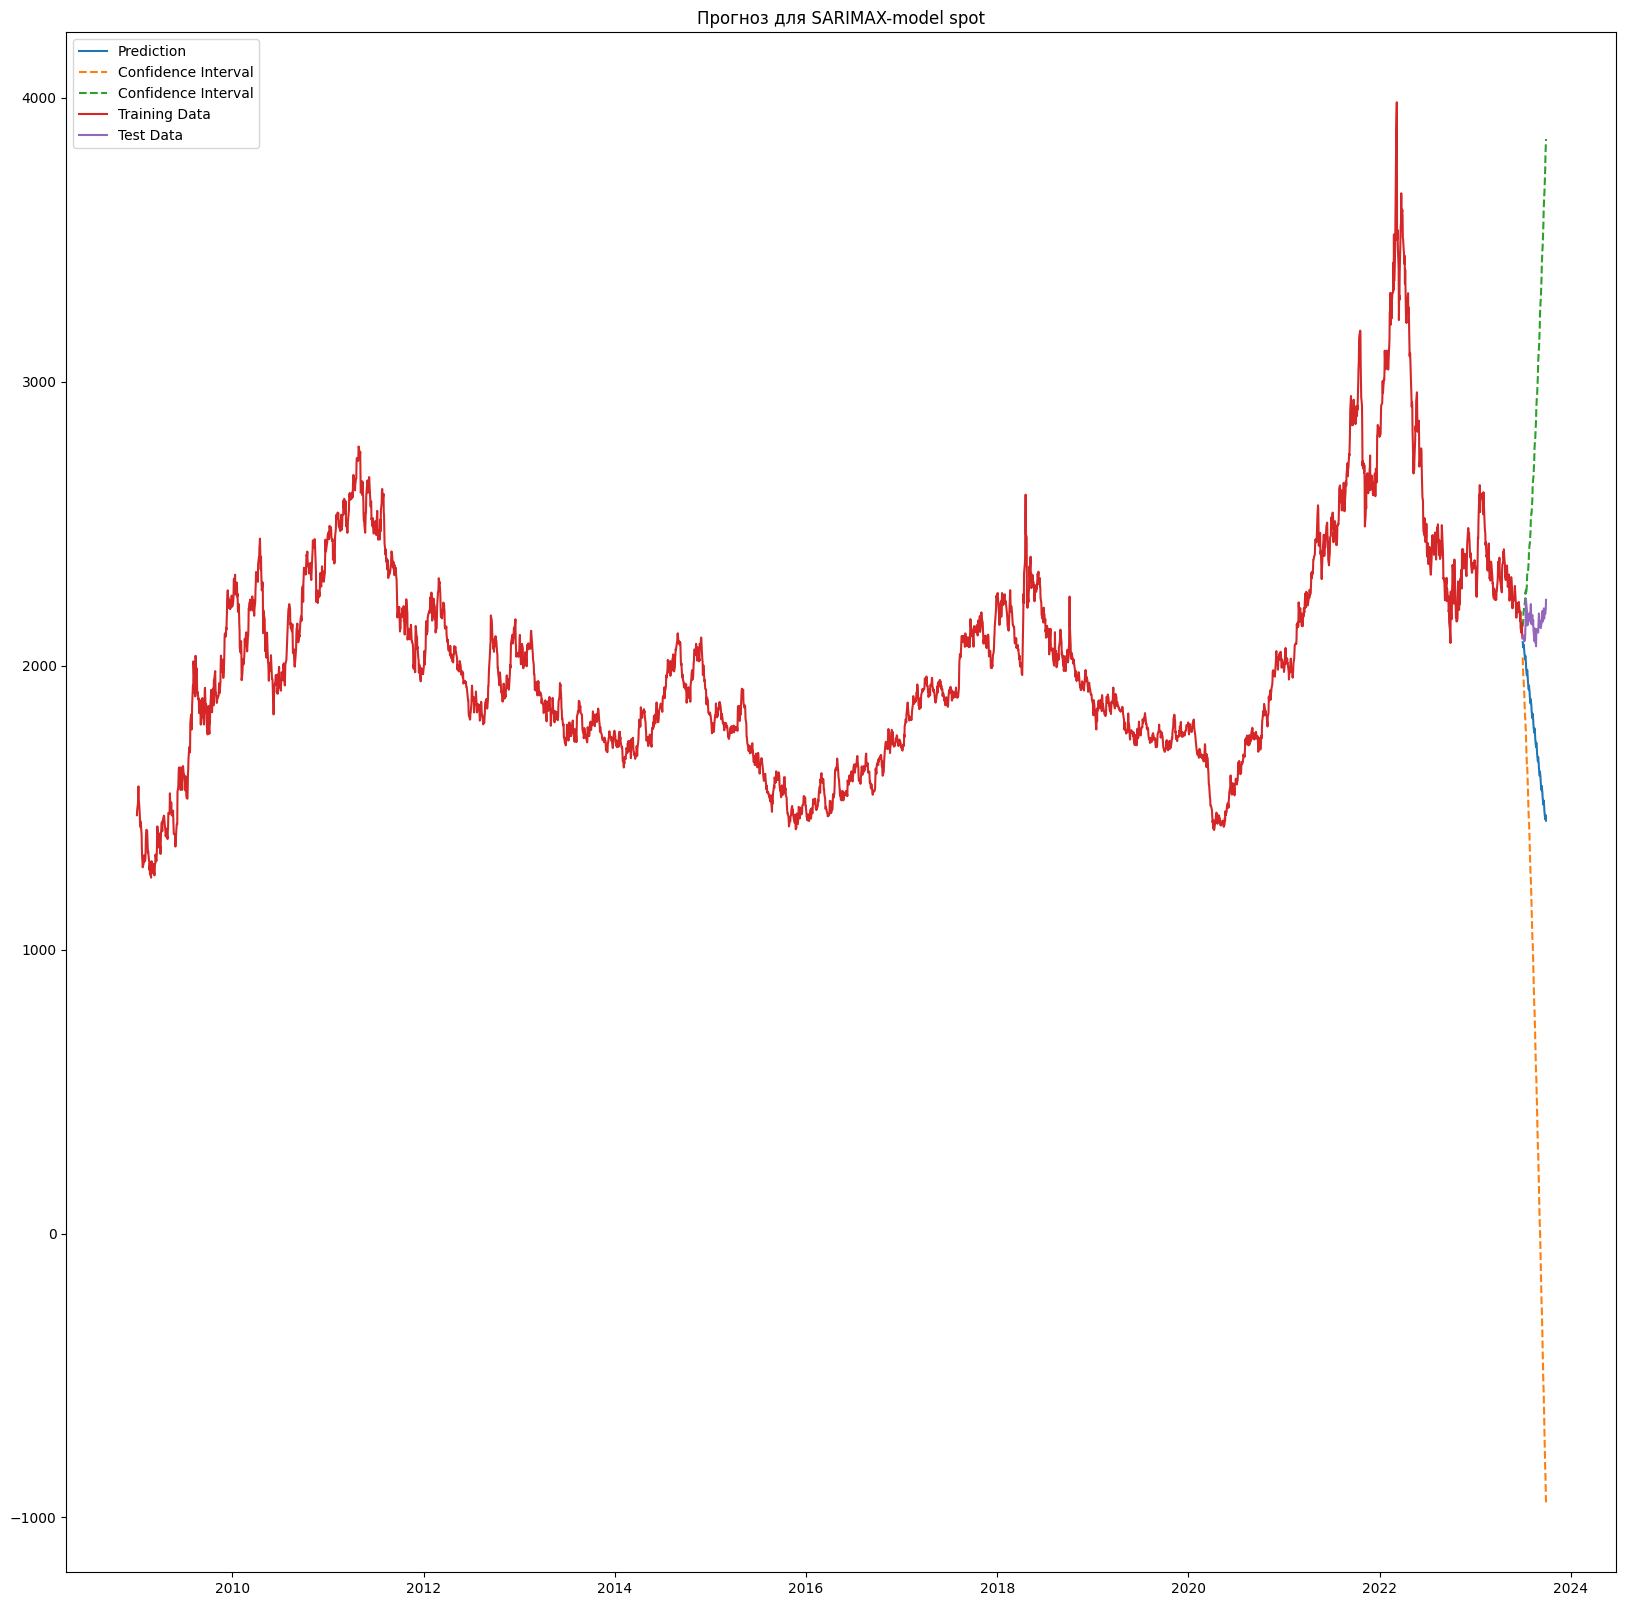

In [156]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_spot, conf_spot,
    train_spot, test_spot, name='SARIMAX-model spot'
)

> Вывод: SARIMAX показал наихудшие результаты, возможно причина заключается в интерполированных данных, либо же влиянии экзогенных факторов не учитываемых в данном анализе (напоминаю нам необходимо разработать легковесный бенчмарк для LME для расчета среднеквартальной цены)

---

### GARCH прогноз для гетероскедастичного ряда.

In [157]:
# Инициализируем модель
garch_stock = arch_model(
    train_stock, lags=1, vol='GARCH',
    p=1, q=1, rescale=True).fit()

garch_spot = arch_model(
    train_spot, lags=1, vol='GARCH',
    p=2, q=1, rescale=True).fit()

# Сделаем предсказание
pred_garch_stock = garch_stock.forecast(
    start=str(train_stock.index[-1]), horizon=90)
pred_garch_spot = garch_spot.forecast(
    start=str(train_spot.index[-1]), horizon=90)

forecast_values = pred_garch_spot.mean.values[-1, :]
for i in range(len(test_spot)):
    print(
        f"Фактическое значение: {test_spot[i]}, Прогнозное значение: {forecast_values[i]}")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32274179397.361515
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2144724016.181079
Iteration:      3,   Func. Count:     20,   Neg. LLF: 253824546803.1853
Iteration:      4,   Func. Count:     27,   Neg. LLF: 23255135210179.367
Iteration:      5,   Func. Count:     35,   Neg. LLF: 44150.10960912368
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21371.40990453094
Iteration:      7,   Func. Count:     48,   Neg. LLF: 20114.374804250285
Iteration:      8,   Func. Count:     54,   Neg. LLF: 20280.33603467028
Iteration:      9,   Func. Count:     60,   Neg. LLF: 21406.87681037895
Iteration:     10,   Func. Count:     67,   Neg. LLF: 20915.738485063444
Iteration:     11,   Func. Count:     73,   Neg. LLF: 19310.54573147997
Iteration:     12,   Func. Count:     78,   Neg. LLF: 19412.071834879986
Iteration:     13,   Func. Count:     90,   Neg. LLF: 19864.64543347242
Iteration:     14,   Func. Count:     98,   Neg. LLF: 18998

> В будущем нам пригодится SARIMAX, хоть сама модель и не подошла, но мы будем прогнозировать дисперсию и накладывать на результаты прогноза спота и запасов.

---

### Перед тем как перейти кследующей части, произведем небольшую манипуляцию с данными для проверки модели с включением экзогенных факторов (для нас это фьючерсы).

In [158]:
# Посмотрим на картины прогнозов для моделей показавших лучший результат
# с использованием авторегрессии
display(pred_ar_stock.tail(15), pred_arima_stock.tail(15))

2023-09-14    494.388580
2023-09-15    493.087775
2023-09-16    492.447028
2023-09-17    491.806239
2023-09-18    491.165408
2023-09-19    492.021245
2023-09-20    490.788745
2023-09-21    489.812702
2023-09-22    488.511292
2023-09-23    487.869941
2023-09-24    487.228547
2023-09-25    486.587112
2023-09-26    487.442344
2023-09-27    486.209239
2023-09-28    485.232591
Freq: D, dtype: float64

2023-09-14    548.597754
2023-09-15    548.669340
2023-09-16    548.740924
2023-09-17    548.812506
2023-09-18    548.884086
2023-09-19    548.955663
2023-09-20    549.027238
2023-09-21    549.098811
2023-09-22    549.170382
2023-09-23    549.241951
2023-09-24    549.313517
2023-09-25    549.385082
2023-09-26    549.456644
2023-09-27    549.528204
2023-09-28    549.599761
Freq: D, dtype: float64

In [159]:
# Выбираем модель для прогноза остатков, тут стоит отметить почему
# выбор пал на базовую модель, дело в том, что различие в метриках
# было не значительно, но сама картина прогнозных запасов выглядит
# реалистичнее ()
best_ts = pred_ar_stock

In [160]:
# Объединим тренировочную выборку по запасам с предсказанием в единый вектор
stock_column = pd.concat([train_stock, best_ts])
stock_column.tail(10)

2023-09-19    492.021245
2023-09-20    490.788745
2023-09-21    489.812702
2023-09-22    488.511292
2023-09-23    487.869941
2023-09-24    487.228547
2023-09-25    486.587112
2023-09-26    487.442344
2023-09-27    486.209239
2023-09-28    485.232591
dtype: float64

In [161]:
# Создадим новую рабочую выборку, она нам понадобится и на этом этапе и для дальнейшего исследования.
working_data_new = pd.concat(
    [working_data[[working_data.columns.to_list()[0], working_data.columns.to_list()[
        1]]], stock_column],
    axis=1).rename(columns={0: working_data.columns.to_list()[2]})

display(working_data.head(), working_data.tail())

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2009-01-01,1473.500000,2301.000000,2333.600000
2009-01-02,1492.000000,2285.666667,2338.300000
2009-01-03,1499.833333,2270.333333,2340.608333
2009-01-04,1507.666667,2255.000000,2342.916667
2009-01-05,1515.500000,2275.000000,2345.225000


,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-24,2188.166667,2155.0,491.800
2023-09-25,2182.500000,2191.5,496.550
2023-09-26,2195.000000,2183.5,494.300
2023-09-27,2196.000000,2152.0,493.300
2023-09-28,2232.000000,2141.5,490.275


In [162]:
# Сформируем трейн/тест для общего случая
train = working_data_new[:len(train_spot)]
test = working_data_new[-len(test_spot):]

In [163]:
# Тренировочная эндогенная
endog_train = train.iloc[:, 0]
# Небольшой пердолинг для экзогенных
exog_train = train.iloc[:, 1:]
exog_test = test.iloc[:, 1:]
# exog_train = pd.concat([exog_train, exog_test], axis=0)

# Тестовая выборка
endog_test = test.iloc[:, 0]

# Горизонт планирования
start = str(endog_test.index.min())
end = str(endog_test.index.max())

In [164]:
# Инициализируем модель, порядок p,d,q возьмем из предлагаемых pdarima
arimax_model_spot = ARIMA(endog_train, exog=exog_train, order=order_spot).fit()

In [165]:
# Спрогнозируем
pred_arimax_spot = arimax_model_spot.predict(
    start=start, end=end, exog=exog_test)

In [166]:
log_metrics_spot(metrics_calculation(
    pred_arimax_spot, endog_test, name='ARIMAX-spot'))

RMSE для ARIMAX-spot: 67.154
MAE для ARIMAX-spot: 56.94
MAPE для ARIMAX-spot: 2.7%




> Хуже чем baseline.

----

### Попробуем методы МО в контексте прогноза запасов

In [167]:
# Реинициализируем выборку
working_data_ml = working_data.reset_index()

working_data_ml = working_data_ml.drop(
    columns=working_data_ml.columns.to_list()[1])

working_data_ml['date'] = working_data_ml['date'].apply(date_format_reverse)

# Сформируем трейн/тест для общего случая
train_ml = working_data_ml[:len(train_spot)]
test_ml = working_data_ml[-len(test_spot):]

# Разобьем на обучающую/тестовую подвыборки
X_train_ml = train_ml.iloc[:, :2]
y_train_ml = train_ml.iloc[:, 2]

X_test_ml = test_ml.iloc[:, :2]
y_test_ml = test_ml.iloc[:, 2]

---

#### Linear Regression

In [168]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model_ml = LinearRegression(
    n_jobs=-1
)

lr_model_ml.fit(X_train_ml, y_train_ml)

pred_lr_model_ml = lr_model_ml.predict(X_test_ml)
pred_lr_model_ml = pd.Series(pred_lr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_lr_model_ml, name='LR-model'))

RMSE для LR-model: 302.387
MAE для LR-model: 301.636
MAPE для LR-model: 59.4%




> Хуже baseline.

---

#### Decision Tree regressor for stock

In [169]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_ml = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_ml.fit(X_train_ml, y_train_ml)
grid_search_dt_ml.best_params_

# Modeling
dt_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)
dt_model.fit(X_train_ml, y_train_ml)

pred_dt_spot_ml = dt_model.predict(X_test_ml)
pred_dt_spot_ml = pd.Series(pred_dt_spot_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_dt_spot_ml, name='DT-model'))

RMSE для DT-model: 22.032
MAE для DT-model: 19.119
MAPE для DT-model: 3.8%




> Незначительно лучше baseline.

---

#### RandomForestRegressor для stock.

In [170]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr_ml = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr_ml.fit(X_train_ml, y_train_ml)
grid_search_rfr_ml.best_params_

# Modelling
rfr_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

rfr_model.fit(X_train_ml, y_train_ml)

pred_rfr_model_ml = rfr_model.predict(X_test_ml)
pred_rfr_model_ml = pd.Series(pred_rfr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_rfr_model_ml, name='RFR-model'))

RMSE для RFR-model: 30.67
MAE для RFR-model: 27.008
MAPE для RFR-model: 5.3%




> Хуже baseline.

----

### Gradient_boost stock

In [171]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr_ml = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr_ml.fit(X_train_ml, y_train_ml)
grid_search_gbr_ml.best_params_

# Modelling
gbr_model_ml = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)

gbr_model_ml.fit(X_train_ml, y_train_ml)

pred_gbr_model_ml = gbr_model_ml.predict(X_test_ml)
pred_gbr_model_ml = pd.Series(pred_gbr_model_ml, test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_gbr_model_ml, name='GBR-model_full'))

RMSE для GBR-model_full: 28.919
MAE для GBR-model_full: 25.161
MAPE для GBR-model_full: 5.0%




> Хуже baseline.

---

### Stacking

In [172]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor_ml = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor_ml.fit(X_train_ml, y_train_ml)

# Получаем предсказания
predictions_ml = stacking_regressor_ml.predict(X_test_ml)

log_metrics_stock(metrics_calculation(
    y_test_ml, predictions_ml, name='Stacking'))

RMSE для Stacking: 599.988
MAE для Stacking: 572.965
MAPE для Stacking: 112.1%




> Хуже baseline.

---

### Посмотрим на результаты моделирования запасов

In [173]:
pd.read_csv('./data/errors/stock_aluminium.csv').sort_values(by='mae')

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,AR-baseline-stock,13.539,11.278,2.2
28,2023-09-29 00:00:00,AR-baseline-stock,13.893,11.369,2.2
30,2023-09-29 00:00:00,PMARIMA-stock,13.819,11.574,2.3
31,2023-09-29 00:00:00,SARIMAX-stock,13.819,11.574,2.3
10,2023-09-27 00:00:00,AR-baseline-stock,14.011,11.626,2.3
19,2023-09-28 00:00:00,AR-baseline-stock,15.270,12.417,2.4
5,2023-09-26 00:00:00,DT-model,21.388,18.489,3.7
15,2023-09-27 00:00:00,DT-model,21.591,18.696,3.7
24,2023-09-28 00:00:00,DT-model,21.816,18.945,3.8
33,2023-09-29 00:00:00,DT-model,22.032,19.119,3.8


> Вывод: Несмотря на небольшое превосходство дерева решений, был принят выбор в сторону AR-baseline в виду того, что:
> 1. Запасы имеют низкую корреляцию с целевой переменной, а следовательно точность их прогнозирования не значительно повлияет на финальный результат.
> 2. При моделировании запасов через дерево, мы опираемся на факторы, которые (spoiler) в последствии будут участвовать в прогнозах цен, что может привнести шум в прогноз.

---

## Часть 2.

#### В данной части мы возьмем модель предсказашую наилучший результат (на рассматриваемых метриках) для остатках запасов, затем используем вектор предсказания как фиты для моделей линейной регрессии, сравним с тестовой выборкой и оценим результат с лучшим результатом для прогноза спотовой цены полученного с помощью анализа временных рядов.

In [174]:
exp_train = train.reset_index(names='date')
exp_test = test.reset_index(names='date')

exp_train['date'] = exp_train['date'].apply(date_format_reverse)
exp_test['date'] = exp_test['date'].apply(date_format_reverse)

In [175]:
# Сформируем трейн/тест для спота
X_train = exp_train.drop(exp_train.columns.tolist()[1], axis=1)
y_train = exp_train[exp_train.columns.tolist()[1]]

X_test = exp_test.drop(exp_test.columns.tolist()[1], axis=1)
y_test = exp_test[exp_test.columns.tolist()[1]]

---

#### Linear Regression

In [176]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

pred_lr_model = lr_model.predict(X_test)
pred_lr_model = pd.Series(pred_lr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_lr_model, name='LR-model'))

RMSE для LR-model: 142.008
MAE для LR-model: 128.46
MAPE для LR-model: 6.0%




> Хуже baseline.

---

#### Decision Tree regressor

In [177]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [178]:
dt_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

# Законсервируем модель на будущее
with open('./data/decision_tree_al.pkl', 'wb') as input:
    pickle.dump(dt_model, input)

dt_model.fit(X_train, y_train)

pred_dt_spot = dt_model.predict(X_test)
pred_dt_spot = pd.Series(pred_dt_spot, index=test.index)
log_metrics_spot(metrics_calculation(y_test, pred_dt_spot, name='DT-model'))

RMSE для DT-model: 245.693
MAE для DT-model: 242.685
MAPE для DT-model: 11.3%




> Хуже baseline, но лучшая из представленных ниже.

---

#### Decision Tree regressor (only futures)

In [179]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_s = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_s.fit(X_train.iloc[:, :-1], y_train)
grid_search_dt_s.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [180]:
dt_model_s = DecisionTreeRegressor(
    **grid_search_dt_s.best_params_,
    random_state=42
)
dt_model_s.fit(X_train.iloc[:, :-1], y_train)

pred_dt_spot_s = dt_model_s.predict(X_test.iloc[:, :-1])
pred_dt_spot_s = pd.Series(pred_dt_spot_s, index=test.index)
log_metrics_spot(metrics_calculation(
    y_test, pred_dt_spot_s, name='DT_simple-model'))

RMSE для DT_simple-model: 245.693
MAE для DT_simple-model: 242.685
MAPE для DT_simple-model: 11.3%




> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе только фючерсов.

In [181]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_srfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_srfr.fit(X_train.iloc[:, :2], y_train)
grid_search_srfr.best_params_

{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}

In [182]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
srfr_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

srfr_model.fit(X_train.iloc[:, :2], y_train)

pred_srfr_model = srfr_model.predict(X_test.iloc[:, :2])
pred_srfr_model = pd.Series(pred_srfr_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_srfr_model, name='RFR-model_no_stock'))

RMSE для RFR-model_no_stock: 211.764
MAE для RFR-model_no_stock: 208.117
MAPE для RFR-model_no_stock: 9.700000000000001%




> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе спрогнозированных запасов.

In [183]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_

{'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 500}

In [184]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

rfr_model.fit(X_train, y_train)

pred_rfr_model = rfr_model.predict(X_test)
pred_rfr_model = pd.Series(pred_rfr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_rfr_model, name='RFR-model'))

RMSE для RFR-model: 211.687
MAE для RFR-model: 208.04
MAPE для RFR-model: 9.700000000000001%




> Хуже baseline.

----

### Gradient_boost stock + futures

In [185]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr.fit(X_train, y_train)
grid_search_gbr.best_params_

{'learning_rate': 0.1,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [186]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)

gbr_model.fit(X_train, y_train)

pred_gbr_model = gbr_model.predict(X_test)
pred_gbr_model = pd.Series(pred_gbr_model, test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbr_model, name='GBR-model_full'))

RMSE для GBR-model_full: 100.939
MAE для GBR-model_full: 87.127
MAPE для GBR-model_full: 4.1000000000000005%




> Хуже baseline.

----

### Gradient_boost futures

In [187]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbrs = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_gbrs.fit(X_train.iloc[:, :2], y_train)
grid_search_gbrs.best_params_

{'learning_rate': 0.1,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [188]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbrs_model = GradientBoostingRegressor(
    **grid_search_gbrs.best_params_,
    random_state=42,
)

gbrs_model.fit(X_train.iloc[:, :2], y_train)

pred_gbrs_model = gbrs_model.predict(X_test.iloc[:, :2])
pred_gbrs_model = pd.Series(pred_gbrs_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbrs_model, name='GBR-model_futures'))

RMSE для GBR-model_futures: 97.072
MAE для GBR-model_futures: 83.82
MAPE для GBR-model_futures: 3.9%




> Хуже baseline.

---

### Stacking

In [189]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor.fit(X_train, y_train)

# Получаем предсказания
predictions = stacking_regressor.predict(X_test)

log_metrics_spot(metrics_calculation(y_test, predictions, name='Stacking'))

RMSE для Stacking: 198.258
MAE для Stacking: 175.547
MAPE для Stacking: 8.200000000000001%




> Хуже baseline.

---

## Часть 3.

### Проверка среднемесячных прогнозов

#### В реальных задачах нас интересуют средние показатели по металлу за месяц и квартал (более далекий горизонт планирования рассматривается лишь в конце года для формирования ТПФП), при том мы расчитываем реальные показатели на неинтерполированном ряду.

#### Первоначальное предположение складывалось из того, что мы понижаем точность прогноза в угоду простоте и мобильности, наша основная цель попасть в окно 250$ на спот при расчете среднемесячного и среднеквартального показателя.

#### В данном случае мы должны сравнить точность на среднемесячных для июля, августа и сентября (то что на данный момент есть), и соответсвенно для 3 квартала (с учетом не полного сентября)


In [190]:
# Посмотрим на модели показавшие наилучший результат по MAE
errors_spot = pd.read_csv('./data/errors/spot_aluminium.csv', sep=',')
errors_spot.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,ARIMAX-spot,38.069,30.554,1.4
1,2023-09-26 00:00:00,ARIMA-spot,38.023,30.698,1.4
2,2023-09-27 00:00:00,ARIMAX-spot,37.561,31.458,1.5
3,2023-09-26 00:00:00,AR-baseline-spot,38.415,32.112,1.5
4,2023-09-26 00:00:00,ARIMA-spot,40.249,34.197,1.6
5,2023-09-27 00:00:00,AR-baseline-spot,40.381,34.518,1.6
6,2023-09-27 00:00:00,ARIMA-spot,43.472,37.270,1.7
7,2023-09-28 00:00:00,ARIMAX-spot,58.402,48.905,2.3
8,2023-09-28 00:00:00,AR-baseline-spot,61.018,51.420,2.4
9,2023-09-28 00:00:00,ARIMA-spot,64.478,54.604,2.5


In [191]:
errors_stock = pd.read_csv('./data/errors/stock_aluminium.csv', sep=',')
errors_stock.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,AR-baseline-stock,13.539,11.278,2.2
1,2023-09-29 00:00:00,AR-baseline-stock,13.893,11.369,2.2
2,2023-09-29 00:00:00,PMARIMA-stock,13.819,11.574,2.3
3,2023-09-29 00:00:00,SARIMAX-stock,13.819,11.574,2.3
4,2023-09-27 00:00:00,AR-baseline-stock,14.011,11.626,2.3
5,2023-09-28 00:00:00,AR-baseline-stock,15.270,12.417,2.4
6,2023-09-26 00:00:00,DT-model,21.388,18.489,3.7
7,2023-09-27 00:00:00,DT-model,21.591,18.696,3.7
8,2023-09-28 00:00:00,DT-model,21.816,18.945,3.8
9,2023-09-29 00:00:00,DT-model,22.032,19.119,3.8


In [192]:
data = pd.read_csv('./data/aluminium.csv',
                   parse_dates=['date'], index_col=['date'])
data.head()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-28,2232.0,2265.0,490.275
2023-09-27,2196.0,2226.0,493.300
2023-09-26,2195.0,2238.5,494.300
2023-09-25,2182.5,2225.0,496.550
2023-09-22,2199.5,2240.0,482.300


In [193]:
# Расчитаем истинное среднее помесячно (горизонт - 3 месяца)
real_data_m = data.reset_index().groupby(
    pd.Grouper(key='date', freq='M')).mean()
real_data_m = real_data_m.tail(3)

real_data_m = real_data_m.reset_index()
columns = real_data_m.columns.to_list()

real_data_m['date'] = pd.to_datetime(real_data_m['date'])
real_data_m = real_data_m.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})
real_data_m = real_data_m.iloc[:, :2]
real_data_m

,Date,LME price_real
0,2023-07-31,2152.380952
1,2023-08-31,2134.159091
2,2023-09-30,2171.000000


In [194]:
pred = pred_dt_spot
final_raw = pd.concat([train_spot, pred]).reset_index()
final_raw = final_raw.rename(columns={'index': 'Date', 0: 'LME price_pred'})


final = final_raw[
    (final_raw['Date'].dt.month.isin([7, 8, 9]))
    & (final_raw['Date'].dt.year == 2023)
]

result_m = pd.DataFrame(final.groupby(
    pd.Grouper(key='Date', freq='M')).mean()).reset_index()

# Округлим до ближайшего десятка, да мы потеряем в точности, но в реальной работе округлние прогнозных цен
# производится до сотни, тем самым мы уже обходим по точности реализуемый подход
result_m = round(result_m, -1)
result_m

,Date,LME price_pred
0,2023-07-31,2390.0
1,2023-08-31,2390.0
2,2023-09-30,2390.0


In [195]:
result_table_m = pd.merge(left=result_m, right=real_data_m)
result_table_m['Delta'] = result_table_m.iloc[:, 1] - \
    result_table_m.iloc[:, 2]

result_table_m['Delta_%'] = (
    result_table_m['Delta']/result_table_m.iloc[:, 2])*100

display(result_table_m)
print(f'Mean delta: {round(result_table_m["Delta"].mean(),4)}')
print(f'Mean delta_%: {round(result_table_m["Delta_%"].mean(),4)}')

,Date,LME price_pred,LME price_real,Delta,Delta_%
0,2023-07-31,2390.0,2152.380952,237.619048,11.039823
1,2023-08-31,2390.0,2134.159091,255.840909,11.987902
2,2023-09-30,2390.0,2171.000000,219.000000,10.087517


Mean delta: 237.4867
Mean delta_%: 11.0384


#### Посмотрим на разброс по среднеквартальному показателю (используем модельный квартал)

In [196]:
# Расчитаем истинное среднее для квартала
real_data_q = data.reset_index()

real_data_q = real_data_q.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})

real_data_q['Date'] = pd.to_datetime(real_data_q['Date'])

real_data_q = real_data_q[
    (real_data_q['Date'].dt.year == 2023) &
    (real_data_q['Date'].dt.month.isin([7, 8, 9]))
]

real_data_q = real_data_q.iloc[:, :2]
quarter_real = round(real_data_q['LME price_real'].mean(), 4)
quarter_real

2151.9286

In [197]:
# Среднее для прогнозного квартала
quarter_pred = round(final['LME price_pred'].mean(), -1)
quarter_pred

2390.0

In [198]:
# Определим дельту между реальным средним и прогнозным по кварталу
quarter_delta = quarter_pred - quarter_real
quarter_delta = round(quarter_delta, 4)
quarter_delta

238.0714

---
---
---

## Часть 4.

#### Воссоздадим модель и прикрутим к ней допфункционал, пока что это будет промежуточный этап перед моделью финального прогноза.

Начнем с самого начала для формирования основного алгоритма действий.
Но для начала опишем какой по итогу план действий был принят:

1. Произвести выгрузку данных из БД.

2. Произвести предобработку данных для последующей отправки на соответсвующий нод.

3. Спрогнозировать дисперсию для корректировки прогнозов по запасам и спотовой цене.

4. Применеть AutoReg (наш baseline) на запасы, для формирования фита Decision Tree Regressor для прогноза цены деревом.

5. Применеть AutoReg (наш baseline) на спот, для формирования прогноза, который будет усредняться с прогнозом дерева (для обеспечения стабильности, т.к. AutoReg имеет тенденцию к заваливанию).

6. Применить Decision Tree Regressor для прогноза цены деревом.

7. Сформировать итоговый прогноз.

8. Вывести итоговый прогноз с добавлением доверительных интервалов в аггрегирующую таблицу и график.

9. Пересобрать каждый этап в виде скрипта и сформировать на их основе микросервисную архитектуру.

P.S. Буду часто использовать английский, т.к. задолбался переключать раскладку.

Ниже представлена схема проекта со связями на нодах.

![Alt text](<data/project_architecture v4-2.png>)

---

#### 1. Data_reconstruction
>

In [227]:
# Инициализируем первичный датасет для авторегрессионного прогноза запасов
data = pd.read_csv(
    './data/aluminium.csv',
    parse_dates=['date'], index_col=['date'])

data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [228]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1] + pd.DateOffset(days=1))
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME stock 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[~data.iloc[:, 2].isna()]

data.set_index('date', inplace=True)

display(data.head(), data.tail())

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2008-04-01,2851.176471,2413.0,993.213235
2008-04-02,2852.252101,2470.5,994.201050
2008-04-03,2853.327731,2498.0,995.188866
2008-04-04,2854.403361,2485.0,996.176681
2008-04-05,2855.478992,2472.0,997.164496


,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-12-24,NaN,2225.0,NaN
2023-12-25,NaN,2238.5,NaN
2023-12-26,NaN,2226.0,NaN
2023-12-27,NaN,2265.0,NaN
2023-12-28,NaN,2342.0,NaN


-----
____

#### Data_reconstructor return

In [229]:
# Разделим датасет на две выборки:
# рабочую информацию (для трейн/тест) и часть
# для будущего прогноза неизвестного периода
split_param = (data.iloc[:, 0].isna()) & (data.iloc[:, 2].isna())
data_target = data[split_param]
working_data = data[~split_param]

# Теперь поделим рабочую выборку
train = working_data.iloc[:-90]
test = working_data.iloc[-90:]

#### Далее описаны связи с другими модулями

---

#### On GARCH Variance_pred for stock and spot

In [230]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-25,2182.5,2191.500000,496.550
2023-09-26,2195.0,2183.500000,494.300
2023-09-27,2196.0,2152.000000,493.300
2023-09-28,2232.0,2141.500000,490.275
2023-09-29,2307.5,2143.333333,486.050


----

#### On Stock_AR (on full real data)

In [231]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-25,2182.5,2191.500000,496.550
2023-09-26,2195.0,2183.500000,494.300
2023-09-27,2196.0,2152.000000,493.300
2023-09-28,2232.0,2141.500000,490.275
2023-09-29,2307.5,2143.333333,486.050


In [232]:
data_target.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-12-24,NaN,2225.0,NaN
2023-12-25,NaN,2238.5,NaN
2023-12-26,NaN,2226.0,NaN
2023-12-27,NaN,2265.0,NaN
2023-12-28,NaN,2342.0,NaN


---

#### On Spot_AR (on real data + target data)

In [233]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-25,2182.5,2191.500000,496.550
2023-09-26,2195.0,2183.500000,494.300
2023-09-27,2196.0,2152.000000,493.300
2023-09-28,2232.0,2141.500000,490.275
2023-09-29,2307.5,2143.333333,486.050


---

#### On prognosis

In [234]:
working_data.tail()

,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
date,,,
2023-09-25,2182.5,2191.500000,496.550
2023-09-26,2195.0,2183.500000,494.300
2023-09-27,2196.0,2152.000000,493.300
2023-09-28,2232.0,2141.500000,490.275
2023-09-29,2307.5,2143.333333,486.050


----
----

#### GARCH Variance_pred for stock and spot
>

##### Stock

На нормальном распределении

In [235]:
# Инициируем рабочий ряд
returns_stock = working_data.iloc[:, -1]

# Начнем моделировать используя параметры из исследования
model_garch_stock = arch_model(
    returns_stock, vol='Garch', p=4, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_stock = model_garch_stock.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_stock = forecast_garch_stock.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
# corr_values_stock = np.random.normal(
#    loc=0, scale=np.sqrt(np.log(forecast_variance_stock)))
corr_values_stock = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_stock))


corr_values_stock = pd.Series(corr_values_stock)

round(corr_values_stock, 3)
corr_values_stock

Iteration:      1,   Func. Count:      9,   Neg. LLF: 102576069267.80963
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2649795275317.666
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2558270357310797.0
Iteration:      4,   Func. Count:     41,   Neg. LLF: 21908.656729347564
Iteration:      5,   Func. Count:     50,   Neg. LLF: 22333.614635252645
Iteration:      6,   Func. Count:     59,   Neg. LLF: 5839961973.814098
Iteration:      7,   Func. Count:     70,   Neg. LLF: 2831139097.818567
Iteration:      8,   Func. Count:     79,   Neg. LLF: 20356.674992066284
Iteration:      9,   Func. Count:     87,   Neg. LLF: 20494.272640816926
Iteration:     10,   Func. Count:    102,   Neg. LLF: 20294.325575786857
Iteration:     11,   Func. Count:    114,   Neg. LLF: 19989.361256349694
Iteration:     12,   Func. Count:    122,   Neg. LLF: 19989.22678230996
Iteration:     13,   Func. Count:    130,   Neg. LLF: 19987.00897476873
Iteration:     14,   Func. Count:    138,   Neg. LLF: 20

0    -10.782541
1      9.546565
2      8.423495
3     -2.167766
4      2.749956
        ...    
85    -1.527345
86     5.137362
87    -8.781618
88    -8.781900
89     6.162682
Length: 90, dtype: float64

##### Spot

In [236]:
# Инициируем рабочий ряд
returns_spot = working_data.iloc[:, 0]

# Начнем моделировать используя параметры из исследования
model_garch_spot = arch_model(
    returns_spot, vol='Garch', p=2, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_spot = model_garch_spot.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_spot = forecast_garch_spot.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
corr_values_spot = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_spot))

corr_values_spot = pd.Series(corr_values_spot)
round(corr_values_spot, 3)
corr_values_spot

Iteration:      1,   Func. Count:      7,   Neg. LLF: 483068.9246224258
Iteration:      2,   Func. Count:     14,   Neg. LLF: 39302.77271124262
Iteration:      3,   Func. Count:     22,   Neg. LLF: 60903.20498316808
Iteration:      4,   Func. Count:     29,   Neg. LLF: 25158.84953531561
Iteration:      5,   Func. Count:     35,   Neg. LLF: 25770.849455286374
Iteration:      6,   Func. Count:     46,   Neg. LLF: 25644.82605447118
Iteration:      7,   Func. Count:     53,   Neg. LLF: 25228.257552052946
Iteration:      8,   Func. Count:     60,   Neg. LLF: 25056.882951111445
Iteration:      9,   Func. Count:     66,   Neg. LLF: 25039.972466171017
Iteration:     10,   Func. Count:     72,   Neg. LLF: 25031.009352502046
Iteration:     11,   Func. Count:     78,   Neg. LLF: 25020.64948126803
Iteration:     12,   Func. Count:     84,   Neg. LLF: 25019.3855978696
Iteration:     13,   Func. Count:     90,   Neg. LLF: 25018.867255559977
Iteration:     14,   Func. Count:     96,   Neg. LLF: 25017

0    -46.431561
1     30.626637
2    -51.743866
3     31.871561
4     -6.734610
        ...    
85   -75.733288
86    71.027792
87    61.156676
88     5.950589
89   -41.436626
Length: 90, dtype: float64

---
---

#### On Stock_AR (on full real data)

In [237]:
display(corr_values_stock)

0    -10.782541
1      9.546565
2      8.423495
3     -2.167766
4      2.749956
        ...    
85    -1.527345
86     5.137362
87    -8.781618
88    -8.781900
89     6.162682
Length: 90, dtype: float64

---

#### On Spot_DT (on real data)

In [238]:
display(corr_values_spot)

0    -46.431561
1     30.626637
2    -51.743866
3     31.871561
4     -6.734610
        ...    
85   -75.733288
86    71.027792
87    61.156676
88     5.950589
89   -41.436626
Length: 90, dtype: float64

---
---

### Stock_AR (on full real data)

In [239]:
# Произведем прогноз моделью AutoReg для запасов
ar_model_real_stock = AutoReg(
    working_data.iloc[:, -1], lags=1, seasonal=True).fit()
pred_real_stock = ar_model_real_stock.predict(
    start=len(working_data), end=len(working_data)+89)

pred_real_stock += corr_values_stock.values

In [240]:
# Создадим копию таргета
forecast_dt = data_target.copy()

# И копию реальных данных
train_dt = working_data.copy()

# Занесем данные по запасам из предсказания
forecast_dt.iloc[:, 2] = pred_real_stock

# Cбросим индексы
train_dt.reset_index(inplace=True)
forecast_dt.reset_index(inplace=True)

# Сформируем датафрейм (train/forecast) для нашего боевого прогноза
columns = forecast_dt.columns.to_list()


def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)


train_dt.iloc[:, 0] = train_dt.iloc[:, 0].apply(date_format_reverse)
forecast_dt.iloc[:, 0] = forecast_dt.iloc[:, 0].apply(date_format_reverse)

---

#### On Spot_DT (on stock prognosis + full real data)

In [241]:
display(train_dt.head())

,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
0,1206986400000,2851.176471,2413.0,993.213235
1,1207072800000,2852.252101,2470.5,994.201050
2,1207159200000,2853.327731,2498.0,995.188866
3,1207245600000,2854.403361,2485.0,996.176681
4,1207332000000,2855.478992,2472.0,997.164496


In [242]:
display(forecast_dt.head())

,date,LME Aluminium Cash-Settlement,LME Aluminium 3-month,LME Aluminium stock
0,1696014000000,NaN,2145.166667,474.965563
1,1696100400000,NaN,2147.000000,494.999655
2,1696186800000,NaN,2156.500000,493.581569
3,1696273200000,NaN,2147.000000,484.431628
4,1696359600000,NaN,2150.000000,488.881566


---
---

### Spot_AR (on real data + target data)

In [243]:
# Произведем прогноз моделью AutoReg для спотовой цены
ar_model_real_spot = AutoReg(
    working_data.iloc[:, 1], lags=2, seasonal=True).fit()
pred_real_spot = ar_model_real_spot.predict(
    start=len(working_data), end=len(working_data)+89)

result_ar = pd.DataFrame(
    pred_real_spot,
    columns=['AutoReg_prognosis'])

---

#### On prognosis adjustment

In [244]:
display(result_ar)

,AutoReg_prognosis
2023-09-30,2142.351012
2023-10-01,2141.408613
2023-10-02,2141.944527
2023-10-03,2141.690312
2023-10-04,2143.463131
...,...
2023-12-24,2126.452077
2023-12-25,2127.014765
2023-12-26,2126.787268
2023-12-27,2128.586757


---
---

### Spot_DT (on stock prognosis + full real data)

In [245]:
X_train = train_dt.drop(columns[1], axis=1)
y_train = train_dt[columns[1]]

X_test = forecast_dt.drop(columns[1], axis=1)

In [246]:
# Распиклим модель с оптимальными параметрами 
# просто что бы показать что умею солить модели
with open('./data/decision_tree_cu.pkl', 'rb') as input:
    dt_pkl_model = pickle.load(input)

In [247]:
# Произведем моделирование
dt_pkl_model.fit(X_train, y_train)

pred_dt_final = dt_pkl_model.predict(X_test) + corr_values_spot.values
pred_dt_final = pd.Series(pred_dt_final)

In [248]:
result_dt = forecast_dt.copy()
result_dt.iloc[:, 1] = pred_dt_final


def date_format(date_raw):
    timestamp = date_raw / 1000
    date = datetime.fromtimestamp(timestamp)
    formatted_date = date.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_date


result_dt.iloc[:, 0] = result_dt.iloc[:, 0].apply(date_format)

result_dt.iloc[:, 0] = pd.to_datetime(result_dt.iloc[:, 0])

result_dt.set_index(result_dt.iloc[:, 0], inplace=True)

result_dt = pd.DataFrame(result_dt.iloc[:, 1])

result_dt = result_dt.rename(
    columns={result_dt.columns.tolist()[0]: 'DecisionTree_prognosis'})

---
---

#### On prognosis

In [249]:
display(result_dt)

,DecisionTree_prognosis
date,
2023-09-30,2109.299042
2023-10-01,2186.357241
2023-10-02,2103.986737
2023-10-03,2187.602165
2023-10-04,2148.995994
...,...
2023-12-24,2079.997315
2023-12-25,2226.758396
2023-12-26,2216.887280


---
---

### Prognosis

In [250]:
adj_df = pd.concat([result_ar, result_dt], axis=1)
adj_df['Final_prognosis'] = np.mean(
    [adj_df['AutoReg_prognosis'], adj_df['DecisionTree_prognosis']], axis=0)
adj_df.dropna(inplace=True)

prognosis_product_day = pd.concat(
    [working_data.iloc[:, 0], adj_df['Final_prognosis']])

display(prognosis_product_day.tail(90))

2023-09-30    2125.825027
2023-10-01    2163.882927
2023-10-02    2122.965632
2023-10-03    2164.646238
2023-10-04    2146.229562
                 ...     
2023-12-24    2103.224696
2023-12-25    2176.886580
2023-12-26    2171.837274
2023-12-27    2145.133975
2023-12-28    2121.170720
Length: 90, dtype: float64

---

### Confidence interval for months

Значение 1.96 используется для расчета доверительного интервала на основе нормального распределения с уровнем доверия 95%. 

В статистике и теории вероятностей, распределение Стьюдента (t-распределение) используется для расчета доверительных интервалов на основе небольших выборок. Однако, при достаточно большом размере выборки (обычно более 30 наблюдений), t-распределение асимптотически приближается к нормальному распределению. 

Для нормального распределения с уровнем доверия 95%, значение 1.96 соответствует двум стандартным отклонениям от среднего значения в каждую сторону (1.96 * стандартное отклонение). Использование этого значения позволяет получить доверительный интервал, который содержит примерно 95% значений из выборки приближенно к нормальному распределению.

In [251]:
prognosis_product_month = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).mean())

prognosis_product_month = prognosis_product_month.rename(columns={0: 'mean'})

prognosis_product_month = prognosis_product_month.iloc[-4:, :]

prognosis_product_month['std'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).std())

prognosis_product_month['num_days'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).count())

prognosis_product_month['min'] = prognosis_product_month['mean'] - 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month['max'] = prognosis_product_month['mean'] + 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month = prognosis_product_month.drop(
    ['std', 'num_days'], axis=1)
prognosis_product_month

,mean,min,max
2023-09-30,2172.527501,2159.829807,2185.225195
2023-10-31,2150.998583,2142.492385,2159.504781
2023-11-30,2152.147680,2143.205837,2161.089523
2023-12-31,2149.486078,2140.706028,2158.266127


---

### Confidence interval for quarer

In [252]:
prognosis_product_q = prognosis_product_day

prognosis_product_q = pd.DataFrame(
    prognosis_product_q.groupby(pd.Grouper(freq='Q')).mean())

prognosis_product_q = prognosis_product_q.rename(columns={0: 'mean'})

prognosis_product_q['std'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).std())

prognosis_product_q['num_days'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).count())

prognosis_product_q['min'] = prognosis_product_q['mean'] - 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q['max'] = prognosis_product_q['mean'] + 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q = prognosis_product_q.drop(columns=['std', 'num_days'])

prognosis_product_q = prognosis_product_q.iloc[-1:, :]

prognosis_product_q = prognosis_product_q.rename(
    index={prognosis_product_q.index[0]: 'Quarter'})

---

#### Final results

In [253]:
result_df = pd.concat([prognosis_product_month, prognosis_product_q], axis=0)
result_df = result_df.round()
result_df

,mean,min,max
2023-09-30 00:00:00,2173.0,2160.0,2185.0
2023-10-31 00:00:00,2151.0,2142.0,2160.0
2023-11-30 00:00:00,2152.0,2143.0,2161.0
2023-12-31 00:00:00,2149.0,2141.0,2158.0
Quarter,2151.0,2146.0,2156.0


---
---

### Line plot

<Axes: xlabel='date', ylabel='LME Aluminium Cash-Settlement'>

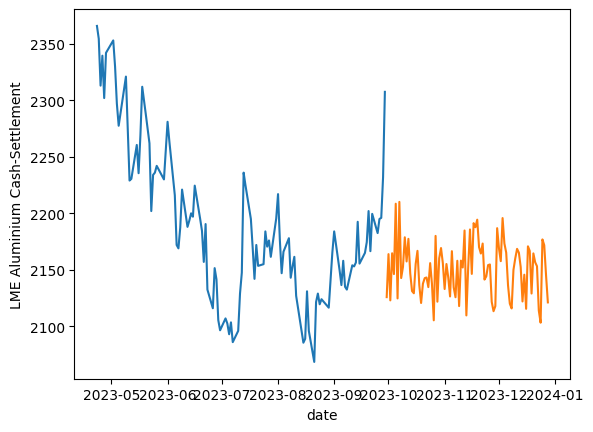

In [254]:
sns.lineplot(working_data.iloc[5500:, 0])
sns.lineplot(adj_df['Final_prognosis'])


---
---